### 데이터 로더

In [1]:
import os
import json
from PIL import Image, UnidentifiedImageError
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

class DriverMonitoringDataset(Dataset):
    def __init__(self, img_root_dir, label_root_dir, transform=None):
        self.img_root_dir = img_root_dir
        self.label_root_dir = label_root_dir
        self.transform = transform
        self.data = self.load_data()
        self.class_to_idx = self.build_class_indices()

    def load_data(self):
        data = []
        for sga_folder in os.listdir(self.img_root_dir):
            ts_img_path = os.path.join(self.img_root_dir, sga_folder)
            ts_label_path = os.path.join(self.label_root_dir, sga_folder)
            
            if os.path.isdir(ts_img_path) and os.path.isdir(ts_label_path):
                for scenario_folder in os.listdir(ts_img_path):
                    img_scenario_path = os.path.join(ts_img_path, scenario_folder, 'img')
                    label_scenario_path = os.path.join(ts_label_path, scenario_folder, 'label')

                    if not os.path.exists(label_scenario_path) or not os.path.exists(img_scenario_path):
                        print(f"Missing label or image folder for scenario: {scenario_folder}")
                        continue

                    for label_file in os.listdir(label_scenario_path):
                        if label_file.endswith('.json'):
                            with open(os.path.join(label_scenario_path, label_file), 'r', encoding='utf-8') as f:
                                try:
                                    label_data = json.load(f)
                                except json.JSONDecodeError:
                                    print(f"Error reading JSON file: {label_file}")
                                    continue
                                
                                if 'scene' not in label_data or 'data' not in label_data['scene']:
                                    print(f"Invalid label data structure in: {label_file}")
                                    continue
                                
                                for img_data in label_data['scene']['data']:
                                    img_name = img_data['img_name']
                                    img_path = os.path.join(img_scenario_path, img_name)
                                    if os.path.exists(img_path):
                                        data.append((img_path, img_data))
                                    else:
                                        print(f"Image file not found: {img_path}")
            else:
                print(f"SGA folder not found or is not a directory: {sga_folder}")
        print(f"Total data loaded: {len(data)} samples")
        return data

    def build_class_indices(self):
        class_to_idx = {}
        for _, img_data in self.data:
            action = img_data['occupant'][0]['action']
            if action not in class_to_idx:
                class_to_idx[action] = len(class_to_idx)
        return class_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, img_data = self.data[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            
            action = img_data['occupant'][0]['action']
            label = self.class_to_idx[action]
            return image, label
        except UnidentifiedImageError:
            print(f"Skipping corrupted image: {img_path}")
            return None, None

def custom_collate_fn(batch):
    # None 요소 제거
    batch = [data for data in batch if data[0] is not None]
    if not batch:
        return torch.empty(0, 3, 224, 224), torch.empty(0, dtype=torch.long)
    return torch.utils.data.default_collate(batch)

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 데이터셋 및 데이터 로더 설정
img_root_dir = r"F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\원천데이터\TS1"
label_root_dir = r"F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\라벨링데이터\TL1"
dataset = DriverMonitoringDataset(img_root_dir=img_root_dir, label_root_dir=label_root_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn, pin_memory=True)

Total data loaded: 238067 samples


### 클래스 매핑 확인

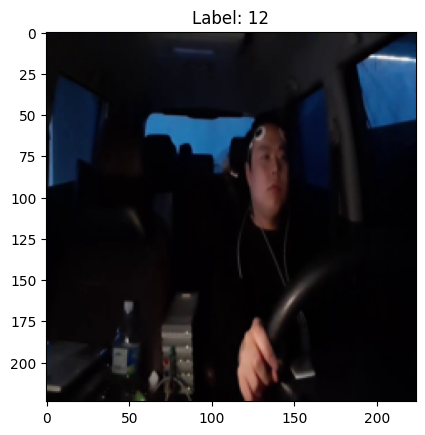

{'무언가를보다': 0, '허리굽히다': 1, '손을뻗다': 2, '몸을돌리다': 3, '핸드폰귀에대기': 4, '고개를돌리다': 5, '옆으로기대다': 6, '운전하다': 7, '힐끗거리다': 8, '중앙을쳐다보다': 9, '핸드폰쥐기': 10, '창문을열다': 11, '핸들을흔들다': 12, '꾸벅꾸벅졸다': 13, '핸들을놓치다': 14, '몸못가누기': 15, '무언가를마시다': 16, '무언가를쥐다': 17, '하품': 18, '중앙으로손을뻗다': 19, '박수치다': 20, '고개를좌우로흔들다': 21, '뺨을때리다': 22, '목을만지다': 23, '어깨를두드리다': 24, '허벅지두드리기': 25, '팔주무르기': 26, '눈비비기': 27, '눈깜빡이기': 28}
Index: 12, Action: 핸들을흔들다


In [2]:
import matplotlib.pyplot as plt

# 데이터 로더에서 하나의 배치를 가져옵니다.
images, labels = next(iter(data_loader))

# 첫 번째 이미지와 라벨 출력
plt.imshow(images[0].permute(1, 2, 0))
plt.title(f"Label: {labels[0].item()}")
plt.show()

# class_to_idx 내용 확인
print(dataset.class_to_idx)

# 첫 번째 이미지와 라벨 출력
first_label = labels[0].item()
print(f"Index: {first_label}, Action: {list(dataset.class_to_idx.keys())[first_label]}")



### 데이터 로더 확인

In [3]:
# 데이터 로더에서 하나의 배치를 가져옵니다.
images, labels = next(iter(data_loader))

# 첫 번째 이미지와 라벨 출력
print(f"Batch size: {images.size()}")
print(f"First label: {labels[0]}")


Batch size: torch.Size([32, 3, 224, 224])
First label: 7


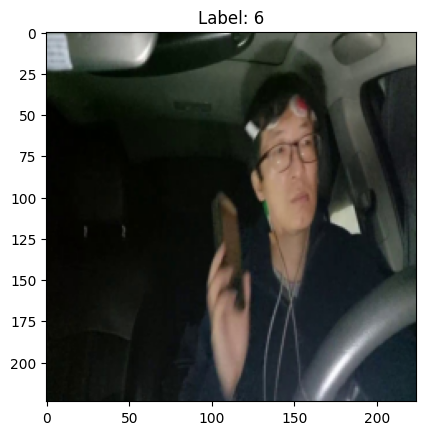

{'무언가를보다': 0, '허리굽히다': 1, '손을뻗다': 2, '몸을돌리다': 3, '핸드폰귀에대기': 4, '고개를돌리다': 5, '옆으로기대다': 6, '운전하다': 7, '힐끗거리다': 8, '중앙을쳐다보다': 9, '핸드폰쥐기': 10, '창문을열다': 11, '핸들을흔들다': 12, '꾸벅꾸벅졸다': 13, '핸들을놓치다': 14, '몸못가누기': 15, '무언가를마시다': 16, '무언가를쥐다': 17, '하품': 18, '중앙으로손을뻗다': 19, '박수치다': 20, '고개를좌우로흔들다': 21, '뺨을때리다': 22, '목을만지다': 23, '어깨를두드리다': 24, '허벅지두드리기': 25, '팔주무르기': 26, '눈비비기': 27, '눈깜빡이기': 28}
Index: 6, Action: 옆으로기대다


In [4]:
import matplotlib.pyplot as plt

# 데이터 로더에서 하나의 배치를 가져옵니다.
images, labels = next(iter(data_loader))

# 첫 번째 이미지와 라벨 출력
plt.imshow(images[0].permute(1, 2, 0))
plt.title(f"Label: {labels[0].item()}")
plt.show()

# class_to_idx 내용 확인
print(dataset.class_to_idx)

# 첫 번째 이미지와 라벨 출력
first_label = labels[0].item()
print(f"Index: {first_label}, Action: {list(dataset.class_to_idx.keys())[first_label]}")



### 각 라벨별 데이터 수 확인

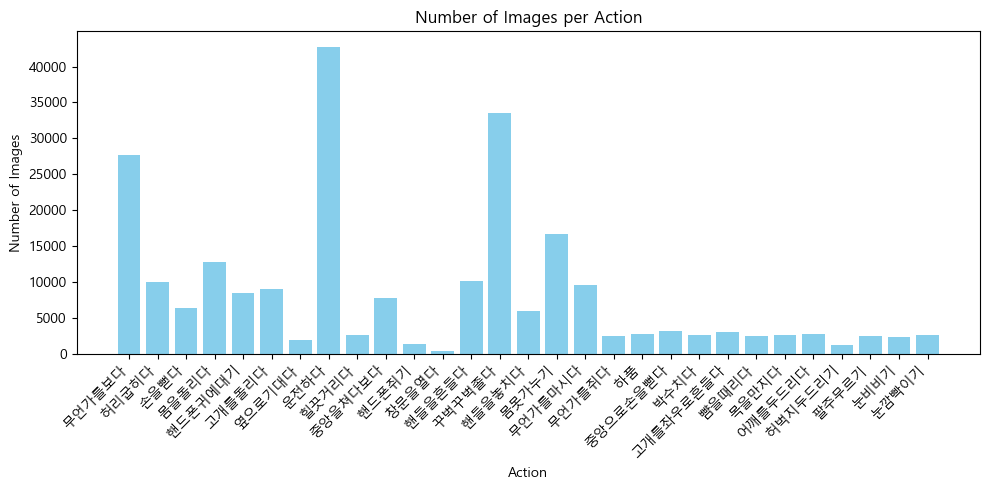

In [5]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rc

# 사용할 폰트 지정 (Windows의 경우 예: 'Malgun Gothic')
font_path = 'C:/Windows/Fonts/malgun.ttf'

# 폰트 설정
font_name = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 데이터셋에서 각 액션별 이미지 수 집계
class_counts = {class_name: 0 for class_name in dataset.class_to_idx.keys()}
for _, img_data in dataset.data:
    action = img_data['occupant'][0]['action']
    class_counts[action] += 1

# 클래스 이름과 해당 이미지 수 리스트로 분리
actions = list(class_counts.keys())
counts = list(class_counts.values())

# 막대 그래프 생성
plt.figure(figsize=(10, 5))
plt.bar(actions, counts, color='skyblue')
plt.xlabel('Action')
plt.ylabel('Number of Images')
plt.title('Number of Images per Action')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

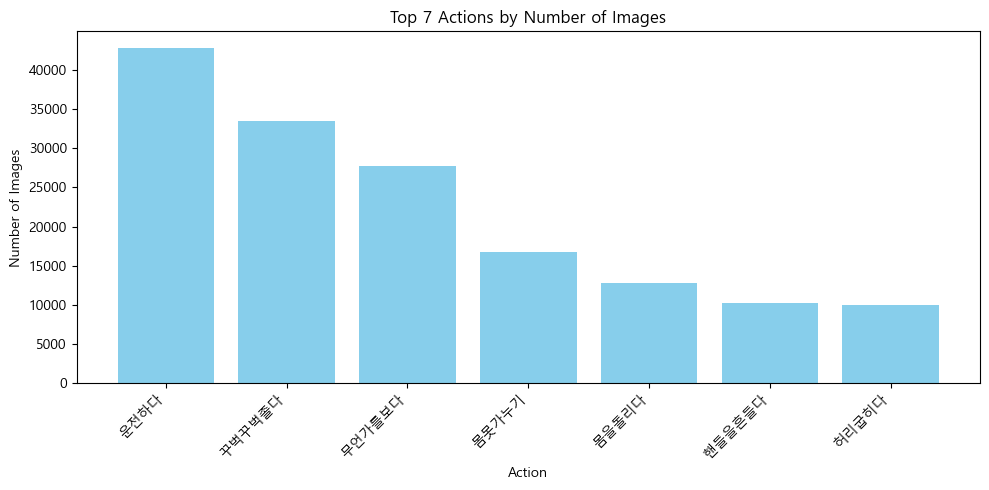

In [6]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rc

# 사용할 폰트 지정 (Windows의 경우 예: 'Malgun Gothic')
font_path = 'C:/Windows/Fonts/malgun.ttf'

# 폰트 설정
font_name = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 데이터셋에서 각 액션별 이미지 수 집계
class_counts = {class_name: 0 for class_name in dataset.class_to_idx.keys()}
for _, img_data in dataset.data:
    action = img_data['occupant'][0]['action']
    class_counts[action] += 1

# 클래스 이름과 해당 이미지 수 리스트로 분리 및 정렬
sorted_class_counts = sorted(class_counts.items(), key=lambda item: item[1], reverse=True)
top_actions, top_counts = zip(*sorted_class_counts[:7])

# 막대 그래프 생성
plt.figure(figsize=(10, 5))
plt.bar(top_actions, top_counts, color='skyblue')
plt.xlabel('Action')
plt.ylabel('Number of Images')
plt.title('Top 7 Actions by Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Resnet-18 model로 이미지 분류 학습

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import os
import random
import numpy as np
from PIL import UnidentifiedImageError

# 랜덤 시드 고정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# 데이터셋 및 학습 설정
total_size = len(dataset)
num_splits = 10  # 10개의 서브샘플로 나누기
num_classes = len(dataset.class_to_idx)
num_epochs = 5
batch_size = 32
learning_rate = 0.0005
print_interval = 100
checkpoint_dir = './final_checkpoint'
os.makedirs(checkpoint_dir, exist_ok=True)
print("Checkpoint directory created.")

# GPU 사용 여부 확인 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 모델 초기화 및 설정
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 설정: 시작할 서브셋과 에포크
start_split = 1  # 0-indexed, 예: 1은 두 번째 서브셋을 의미
start_epoch = 0  # 0-indexed, 예: 0은 첫 번째 에포크를 의미

# 체크포인트 불러오기 - subset_1_epoch_5.pth
checkpoint_path = os.path.join(checkpoint_dir, 'subset_1_epoch_5_checkpoint.pth')
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Loaded checkpoint from {checkpoint_path}")

# 데이터셋을 10등분하여 학습
for split_index in range(start_split, num_splits):
    # 서브셈플링 인덱스 설정
    indices = list(range(total_size))
    random.shuffle(indices)
    split_size = total_size // num_splits
    subset_indices = indices[split_index * split_size:(split_index + 1) * split_size]
    subset = Subset(dataset, subset_indices)

    # custom_collate_fn 정의
    def custom_collate_fn(batch):
        batch = [item for item in batch if item[0] is not None]
        if not batch:
            return torch.empty(0, 3, 224, 224), torch.empty(0, dtype=torch.long)
        return torch.utils.data.default_collate(batch)

    # 데이터 로더 설정
    data_loader = DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, collate_fn=custom_collate_fn)
    print(f"\nStarting training for subset {split_index + 1}/{num_splits}...")

    # 학습 루프
    for epoch in range(start_epoch if split_index == start_split else 0, num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs} for subset {split_index + 1}...")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch + 1} Progress")):
            try:
                images = images.to(device)
                labels = labels.to(device)
                
                # 예측 및 손실 계산
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # 역전파 및 최적화
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # 통계 업데이트
                running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # 각 배치마다의 loss와 accuracy 출력
                if (batch_idx + 1) % print_interval == 0:
                    batch_loss = loss.item()
                    batch_acc = (predicted.eq(labels).sum().item() / labels.size(0))
                    print(f"[Batch {batch_idx + 1}/{len(data_loader)}] Batch Loss: {batch_loss:.4f}, Batch Accuracy: {batch_acc:.4f}")
            except UnidentifiedImageError as e:
                print(f"Skipping corrupted image: {e}")
                pass
            except Exception as e:
                print(f"Unexpected error: {e}")
                pass

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        print(f'Epoch {epoch + 1} for subset {split_index + 1} complete. Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        
        # 체크포인트 저장
        checkpoint_path = os.path.join(checkpoint_dir, f'subset_{split_index + 1}_epoch_{epoch + 1}_checkpoint.pth')
        torch.save({
            'subset': split_index + 1,
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'accuracy': epoch_acc
        }, checkpoint_path)
        print(f'Checkpoint saved at {checkpoint_path}')

    start_epoch = 0  # 다음 서브셋으로 넘어갈 때 에포크를 0으로 리셋
    print(f"Training for subset {split_index + 1}/{num_splits} completed.")
print("All subsets training completed.")


Checkpoint directory created.
Using device: cpu
Loaded checkpoint from ./final_checkpoint\subset_1_epoch_5_checkpoint.pth

Starting training for subset 2/10...

Epoch 1/5 for subset 2...


Epoch 1 Progress:  13%|█▎        | 100/744 [03:32<23:53,  2.23s/it]

[Batch 100/744] Batch Loss: 0.8358, Batch Accuracy: 0.7812


Epoch 1 Progress:  27%|██▋       | 200/744 [07:33<22:30,  2.48s/it]

[Batch 200/744] Batch Loss: 0.8842, Batch Accuracy: 0.6875


Epoch 1 Progress:  40%|████      | 300/744 [11:48<19:26,  2.63s/it]

[Batch 300/744] Batch Loss: 0.8561, Batch Accuracy: 0.6562


Epoch 1 Progress:  54%|█████▍    | 400/744 [16:10<13:52,  2.42s/it]

[Batch 400/744] Batch Loss: 0.6404, Batch Accuracy: 0.6875


Epoch 1 Progress:  67%|██████▋   | 500/744 [20:18<09:29,  2.34s/it]

[Batch 500/744] Batch Loss: 0.3968, Batch Accuracy: 0.9375


Epoch 1 Progress:  81%|████████  | 600/744 [24:17<05:48,  2.42s/it]

[Batch 600/744] Batch Loss: 0.6943, Batch Accuracy: 0.6875


Epoch 1 Progress:  94%|█████████▍| 700/744 [28:15<01:43,  2.36s/it]

[Batch 700/744] Batch Loss: 0.7932, Batch Accuracy: 0.6562


Epoch 1 Progress: 100%|██████████| 744/744 [30:00<00:00,  2.42s/it]


Epoch 1 for subset 2 complete. Loss: 0.8939, Accuracy: 0.7222
Checkpoint saved at ./final_checkpoint\subset_2_epoch_1_checkpoint.pth

Epoch 2/5 for subset 2...


Epoch 2 Progress:  13%|█▎        | 100/744 [03:43<24:00,  2.24s/it]

[Batch 100/744] Batch Loss: 0.5201, Batch Accuracy: 0.8438


Epoch 2 Progress:  27%|██▋       | 200/744 [07:39<21:44,  2.40s/it]

[Batch 200/744] Batch Loss: 0.6134, Batch Accuracy: 0.7500


Epoch 2 Progress:  40%|████      | 300/744 [11:39<18:13,  2.46s/it]

[Batch 300/744] Batch Loss: 0.6714, Batch Accuracy: 0.7812


Epoch 2 Progress:  54%|█████▍    | 400/744 [15:43<13:51,  2.42s/it]

[Batch 400/744] Batch Loss: 0.5120, Batch Accuracy: 0.8125


Epoch 2 Progress:  67%|██████▋   | 500/744 [19:44<09:18,  2.29s/it]

[Batch 500/744] Batch Loss: 0.6731, Batch Accuracy: 0.6875


Epoch 2 Progress:  81%|████████  | 600/744 [23:35<05:40,  2.36s/it]

[Batch 600/744] Batch Loss: 0.8319, Batch Accuracy: 0.6875


Epoch 2 Progress:  94%|█████████▍| 700/744 [27:34<01:44,  2.38s/it]

[Batch 700/744] Batch Loss: 0.8310, Batch Accuracy: 0.7188


Epoch 2 Progress: 100%|██████████| 744/744 [29:18<00:00,  2.36s/it]


Epoch 2 for subset 2 complete. Loss: 0.6738, Accuracy: 0.7780
Checkpoint saved at ./final_checkpoint\subset_2_epoch_2_checkpoint.pth

Epoch 3/5 for subset 2...


Epoch 3 Progress:  13%|█▎        | 100/744 [03:37<23:21,  2.18s/it]

[Batch 100/744] Batch Loss: 0.5569, Batch Accuracy: 0.7500


Epoch 3 Progress:  27%|██▋       | 200/744 [07:14<19:44,  2.18s/it]

[Batch 200/744] Batch Loss: 0.3478, Batch Accuracy: 0.8438


Epoch 3 Progress:  40%|████      | 300/744 [10:50<16:14,  2.20s/it]

[Batch 300/744] Batch Loss: 0.6534, Batch Accuracy: 0.7188


Epoch 3 Progress:  54%|█████▍    | 400/744 [14:26<12:37,  2.20s/it]

[Batch 400/744] Batch Loss: 0.3970, Batch Accuracy: 0.8750


Epoch 3 Progress:  67%|██████▋   | 500/744 [18:03<08:44,  2.15s/it]

[Batch 500/744] Batch Loss: 0.2448, Batch Accuracy: 0.9375


Epoch 3 Progress:  81%|████████  | 600/744 [21:43<05:15,  2.19s/it]

[Batch 600/744] Batch Loss: 0.5579, Batch Accuracy: 0.7812


Epoch 3 Progress:  94%|█████████▍| 700/744 [25:25<01:40,  2.28s/it]

[Batch 700/744] Batch Loss: 0.5806, Batch Accuracy: 0.7500


Epoch 3 Progress: 100%|██████████| 744/744 [27:05<00:00,  2.18s/it]


Epoch 3 for subset 2 complete. Loss: 0.5265, Accuracy: 0.8196
Checkpoint saved at ./final_checkpoint\subset_2_epoch_3_checkpoint.pth

Epoch 4/5 for subset 2...


Epoch 4 Progress:  13%|█▎        | 100/744 [03:32<23:02,  2.15s/it]

[Batch 100/744] Batch Loss: 0.5396, Batch Accuracy: 0.8438


Epoch 4 Progress:  27%|██▋       | 200/744 [07:07<19:30,  2.15s/it]

[Batch 200/744] Batch Loss: 0.4893, Batch Accuracy: 0.7812


Epoch 4 Progress:  40%|████      | 300/744 [10:44<16:12,  2.19s/it]

[Batch 300/744] Batch Loss: 0.5106, Batch Accuracy: 0.7500


Epoch 4 Progress:  54%|█████▍    | 400/744 [14:35<13:21,  2.33s/it]

[Batch 400/744] Batch Loss: 0.5855, Batch Accuracy: 0.8125


Epoch 4 Progress:  67%|██████▋   | 500/744 [18:31<09:30,  2.34s/it]

[Batch 500/744] Batch Loss: 0.3999, Batch Accuracy: 0.8125


Epoch 4 Progress:  81%|████████  | 600/744 [22:28<05:45,  2.40s/it]

[Batch 600/744] Batch Loss: 0.3342, Batch Accuracy: 0.9062


Epoch 4 Progress:  94%|█████████▍| 700/744 [26:35<01:48,  2.47s/it]

[Batch 700/744] Batch Loss: 0.6195, Batch Accuracy: 0.7812


Epoch 4 Progress: 100%|██████████| 744/744 [28:24<00:00,  2.29s/it]


Epoch 4 for subset 2 complete. Loss: 0.4217, Accuracy: 0.8565
Checkpoint saved at ./final_checkpoint\subset_2_epoch_4_checkpoint.pth

Epoch 5/5 for subset 2...


Epoch 5 Progress:  13%|█▎        | 100/744 [03:42<23:57,  2.23s/it]

[Batch 100/744] Batch Loss: 0.3005, Batch Accuracy: 0.9062


Epoch 5 Progress:  27%|██▋       | 200/744 [07:27<20:45,  2.29s/it]

[Batch 200/744] Batch Loss: 0.1223, Batch Accuracy: 0.9688


Epoch 5 Progress:  40%|████      | 300/744 [11:11<16:28,  2.23s/it]

[Batch 300/744] Batch Loss: 0.3217, Batch Accuracy: 0.8750


Epoch 5 Progress:  54%|█████▍    | 400/744 [14:57<12:57,  2.26s/it]

[Batch 400/744] Batch Loss: 0.3866, Batch Accuracy: 0.8438


Epoch 5 Progress:  67%|██████▋   | 500/744 [18:47<09:38,  2.37s/it]

[Batch 500/744] Batch Loss: 0.2045, Batch Accuracy: 0.9375


Epoch 5 Progress:  81%|████████  | 600/744 [22:36<05:23,  2.25s/it]

[Batch 600/744] Batch Loss: 0.2228, Batch Accuracy: 0.9375


Epoch 5 Progress:  94%|█████████▍| 700/744 [26:30<01:47,  2.45s/it]

[Batch 700/744] Batch Loss: 0.2918, Batch Accuracy: 0.8750


Epoch 5 Progress: 100%|██████████| 744/744 [28:15<00:00,  2.28s/it]


Epoch 5 for subset 2 complete. Loss: 0.3344, Accuracy: 0.8859
Checkpoint saved at ./final_checkpoint\subset_2_epoch_5_checkpoint.pth
Training for subset 2/10 completed.

Starting training for subset 3/10...

Epoch 1/5 for subset 3...


Epoch 1 Progress:   0%|          | 1/744 [00:03<39:56,  3.23s/it]


KeyboardInterrupt: 

### learning_rage를 0.0001로 줄이고, bathch size를 64로 키움

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import os
import random
import numpy as np
from PIL import UnidentifiedImageError

# 랜덤 시드 고정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# 데이터셋 및 학습 설정
total_size = len(dataset)
num_splits = 10  # 10개의 서브샘플로 나누기
num_classes = len(dataset.class_to_idx)
num_epochs = 5
batch_size = 64
learning_rate = 0.0001
print_interval = 30
checkpoint_dir = './final_checkpoint'
os.makedirs(checkpoint_dir, exist_ok=True)
print("Checkpoint directory created.")

# GPU 사용 여부 확인 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 모델 초기화 및 설정
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 설정: 시작할 서브셋과 에포크
start_split = 2  # 0-indexed, 예: 1은 두 번째 서브셋을 의미
start_epoch = 0  # 0-indexed, 예: 0은 첫 번째 에포크를 의미

# 체크포인트 불러오기 - subset_1_epoch_5.pth
checkpoint_path = os.path.join(checkpoint_dir, 'subset_2_epoch_5_checkpoint.pth')
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Loaded checkpoint from {checkpoint_path}")

# 데이터셋을 10등분하여 학습
for split_index in range(start_split, num_splits):
    # 서브셈플링 인덱스 설정
    indices = list(range(total_size))
    random.shuffle(indices)
    split_size = total_size // num_splits
    subset_indices = indices[split_index * split_size:(split_index + 1) * split_size]
    subset = Subset(dataset, subset_indices)

    # custom_collate_fn 정의
    def custom_collate_fn(batch):
        batch = [item for item in batch if item[0] is not None]
        if not batch:
            return torch.empty(0, 3, 224, 224), torch.empty(0, dtype=torch.long)
        return torch.utils.data.default_collate(batch)

    # 데이터 로더 설정
    data_loader = DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, collate_fn=custom_collate_fn)
    print(f"\nStarting training for subset {split_index + 1}/{num_splits}...")

    # 학습 루프
    for epoch in range(start_epoch if split_index == start_split else 0, num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs} for subset {split_index + 1}...")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch + 1} Progress")):
            try:
                images = images.to(device)
                labels = labels.to(device)
                
                # 예측 및 손실 계산
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # 역전파 및 최적화
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # 통계 업데이트
                running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # 각 배치마다의 loss와 accuracy 출력
                if (batch_idx + 1) % print_interval == 0:
                    batch_loss = loss.item()
                    batch_acc = (predicted.eq(labels).sum().item() / labels.size(0))
                    print(f"[Batch {batch_idx + 1}/{len(data_loader)}] Batch Loss: {batch_loss:.4f}, Batch Accuracy: {batch_acc:.4f}")
            except UnidentifiedImageError as e:
                print(f"Skipping corrupted image: {e}")
                pass
            except Exception as e:
                print(f"Unexpected error: {e}")
                pass

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        print(f'Epoch {epoch + 1} for subset {split_index + 1} complete. Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        
        # 체크포인트 저장
        checkpoint_path = os.path.join(checkpoint_dir, f'subset_{split_index + 1}_epoch_{epoch + 1}_checkpoint.pth')
        torch.save({
            'subset': split_index + 1,
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'accuracy': epoch_acc
        }, checkpoint_path)
        print(f'Checkpoint saved at {checkpoint_path}')

    start_epoch = 0  # 다음 서브셋으로 넘어갈 때 에포크를 0으로 리셋
    print(f"Training for subset {split_index + 1}/{num_splits} completed.")
print("All subsets training completed.")


Checkpoint directory created.
Using device: cpu
Loaded checkpoint from ./final_checkpoint\subset_2_epoch_5_checkpoint.pth

Starting training for subset 3/10...

Epoch 1/5 for subset 3...


Epoch 1 Progress:   8%|▊         | 30/372 [02:25<26:30,  4.65s/it]

[Batch 30/372] Batch Loss: 0.5762, Batch Accuracy: 0.8281


Epoch 1 Progress:  16%|█▌        | 60/372 [04:58<25:26,  4.89s/it]

[Batch 60/372] Batch Loss: 0.6051, Batch Accuracy: 0.8438


Epoch 1 Progress:  24%|██▍       | 90/372 [07:20<22:50,  4.86s/it]

[Batch 90/372] Batch Loss: 0.4350, Batch Accuracy: 0.8594


Epoch 1 Progress:  32%|███▏      | 120/372 [09:43<20:07,  4.79s/it]

[Batch 120/372] Batch Loss: 0.8567, Batch Accuracy: 0.7656


Epoch 1 Progress:  40%|████      | 150/372 [12:08<17:50,  4.82s/it]

[Batch 150/372] Batch Loss: 0.9043, Batch Accuracy: 0.7031


Epoch 1 Progress:  48%|████▊     | 180/372 [14:33<15:28,  4.83s/it]

[Batch 180/372] Batch Loss: 0.5686, Batch Accuracy: 0.8125


Epoch 1 Progress:  56%|█████▋    | 210/372 [16:57<12:59,  4.81s/it]

[Batch 210/372] Batch Loss: 0.7749, Batch Accuracy: 0.7656


Epoch 1 Progress:  65%|██████▍   | 240/372 [19:23<10:32,  4.79s/it]

[Batch 240/372] Batch Loss: 0.3818, Batch Accuracy: 0.8438


Epoch 1 Progress:  73%|███████▎  | 270/372 [21:46<08:09,  4.80s/it]

[Batch 270/372] Batch Loss: 0.7811, Batch Accuracy: 0.7500


Epoch 1 Progress:  81%|████████  | 300/372 [24:10<05:41,  4.74s/it]

[Batch 300/372] Batch Loss: 0.3979, Batch Accuracy: 0.8438


Epoch 1 Progress:  89%|████████▊ | 330/372 [26:34<03:22,  4.82s/it]

[Batch 330/372] Batch Loss: 0.7373, Batch Accuracy: 0.7812


Epoch 1 Progress:  92%|█████████▏| 341/372 [27:26<02:28,  4.81s/it]

Skipping corrupted image: F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\원천데이터\TS1\SGA2100062\SGA2100062S0057\img\SGA2100062S0057IMG0004.jpg


Epoch 1 Progress:  97%|█████████▋| 360/372 [28:58<00:57,  4.79s/it]

[Batch 360/372] Batch Loss: 0.7937, Batch Accuracy: 0.7500


Epoch 1 Progress:  99%|█████████▉| 369/372 [29:41<00:14,  4.79s/it]

Skipping corrupted image: F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\원천데이터\TS1\SGA2100065\SGA2100065S0119\img\SGA2100065S0119IMG0005.jpg


Epoch 1 Progress: 100%|██████████| 372/372 [29:55<00:00,  4.83s/it]


Epoch 1 for subset 3 complete. Loss: 0.7012, Accuracy: 0.7808
Checkpoint saved at ./final_checkpoint\subset_3_epoch_1_checkpoint.pth

Epoch 2/5 for subset 3...


Epoch 2 Progress:   8%|▊         | 30/372 [02:09<24:29,  4.30s/it]

[Batch 30/372] Batch Loss: 0.3320, Batch Accuracy: 0.8906


Epoch 2 Progress:  16%|█▌        | 60/372 [04:19<22:23,  4.31s/it]

[Batch 60/372] Batch Loss: 0.5292, Batch Accuracy: 0.7969


Epoch 2 Progress:  24%|██▍       | 90/372 [06:35<21:15,  4.52s/it]

[Batch 90/372] Batch Loss: 0.2882, Batch Accuracy: 0.9219


Epoch 2 Progress:  32%|███▏      | 120/372 [08:50<18:19,  4.36s/it]

[Batch 120/372] Batch Loss: 0.4135, Batch Accuracy: 0.8594


Epoch 2 Progress:  37%|███▋      | 138/372 [10:09<17:38,  4.52s/it]

Skipping corrupted image: F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\원천데이터\TS1\SGA2100062\SGA2100062S0057\img\SGA2100062S0057IMG0004.jpg


Epoch 2 Progress:  40%|████      | 150/372 [10:57<14:57,  4.05s/it]

[Batch 150/372] Batch Loss: 0.3350, Batch Accuracy: 0.8750


Epoch 2 Progress:  48%|████▊     | 180/372 [12:56<12:48,  4.00s/it]

[Batch 180/372] Batch Loss: 0.4192, Batch Accuracy: 0.8750


Epoch 2 Progress:  56%|█████▋    | 210/372 [14:56<10:56,  4.06s/it]

[Batch 210/372] Batch Loss: 0.2619, Batch Accuracy: 0.9219


Epoch 2 Progress:  65%|██████▍   | 240/372 [16:56<08:47,  3.99s/it]

[Batch 240/372] Batch Loss: 0.3812, Batch Accuracy: 0.8594


Epoch 2 Progress:  73%|███████▎  | 270/372 [18:55<06:48,  4.01s/it]

[Batch 270/372] Batch Loss: 0.3091, Batch Accuracy: 0.9062


Epoch 2 Progress:  81%|████████  | 300/372 [20:55<04:41,  3.91s/it]

[Batch 300/372] Batch Loss: 0.4257, Batch Accuracy: 0.8594


Epoch 2 Progress:  81%|████████  | 302/372 [21:03<04:34,  3.92s/it]

Skipping corrupted image: F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\원천데이터\TS1\SGA2100065\SGA2100065S0119\img\SGA2100065S0119IMG0005.jpg


Epoch 2 Progress:  89%|████████▊ | 330/372 [22:55<02:49,  4.03s/it]

[Batch 330/372] Batch Loss: 0.3188, Batch Accuracy: 0.9219


Epoch 2 Progress:  97%|█████████▋| 360/372 [25:06<00:59,  4.95s/it]

[Batch 360/372] Batch Loss: 0.4962, Batch Accuracy: 0.8281


Epoch 2 Progress: 100%|██████████| 372/372 [26:11<00:00,  4.22s/it]


Epoch 2 for subset 3 complete. Loss: 0.3985, Accuracy: 0.8620
Checkpoint saved at ./final_checkpoint\subset_3_epoch_2_checkpoint.pth

Epoch 3/5 for subset 3...


Epoch 3 Progress:   8%|▊         | 30/372 [02:12<25:01,  4.39s/it]

[Batch 30/372] Batch Loss: 0.2619, Batch Accuracy: 0.8906


Epoch 3 Progress:  16%|█▌        | 60/372 [04:30<23:13,  4.47s/it]

[Batch 60/372] Batch Loss: 0.2344, Batch Accuracy: 0.8906


Epoch 3 Progress:  24%|██▍       | 90/372 [06:45<20:45,  4.42s/it]

[Batch 90/372] Batch Loss: 0.3737, Batch Accuracy: 0.8750


Epoch 3 Progress:  32%|███▏      | 120/372 [09:00<19:00,  4.53s/it]

[Batch 120/372] Batch Loss: 0.3147, Batch Accuracy: 0.8906


Epoch 3 Progress:  40%|████      | 150/372 [11:17<17:33,  4.75s/it]

[Batch 150/372] Batch Loss: 0.1499, Batch Accuracy: 0.9531


Epoch 3 Progress:  48%|████▊     | 180/372 [13:38<15:06,  4.72s/it]

[Batch 180/372] Batch Loss: 0.1748, Batch Accuracy: 0.9531


Epoch 3 Progress:  56%|█████▋    | 210/372 [15:54<11:45,  4.35s/it]

[Batch 210/372] Batch Loss: 0.3238, Batch Accuracy: 0.9062


Epoch 3 Progress:  65%|██████▍   | 240/372 [18:05<09:37,  4.37s/it]

[Batch 240/372] Batch Loss: 0.3904, Batch Accuracy: 0.8906


Epoch 3 Progress:  66%|██████▌   | 245/372 [18:27<09:13,  4.36s/it]

Skipping corrupted image: F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\원천데이터\TS1\SGA2100062\SGA2100062S0057\img\SGA2100062S0057IMG0004.jpg


Epoch 3 Progress:  73%|███████▎  | 270/372 [20:15<07:23,  4.35s/it]

[Batch 270/372] Batch Loss: 0.3477, Batch Accuracy: 0.9062


Epoch 3 Progress:  81%|████████  | 300/372 [22:26<05:10,  4.31s/it]

[Batch 300/372] Batch Loss: 0.1748, Batch Accuracy: 0.9219


Epoch 3 Progress:  87%|████████▋ | 324/372 [24:13<03:32,  4.43s/it]

Skipping corrupted image: F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\원천데이터\TS1\SGA2100065\SGA2100065S0119\img\SGA2100065S0119IMG0005.jpg


Epoch 3 Progress:  89%|████████▊ | 330/372 [24:39<03:04,  4.38s/it]

[Batch 330/372] Batch Loss: 0.3648, Batch Accuracy: 0.8594


Epoch 3 Progress:  97%|█████████▋| 360/372 [26:49<00:52,  4.36s/it]

[Batch 360/372] Batch Loss: 0.3514, Batch Accuracy: 0.8906


Epoch 3 Progress: 100%|██████████| 372/372 [27:42<00:00,  4.47s/it]


Epoch 3 for subset 3 complete. Loss: 0.2520, Accuracy: 0.9106
Checkpoint saved at ./final_checkpoint\subset_3_epoch_3_checkpoint.pth

Epoch 4/5 for subset 3...


Epoch 4 Progress:   1%|▏         | 5/372 [00:20<25:20,  4.14s/it]

Skipping corrupted image: F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\원천데이터\TS1\SGA2100062\SGA2100062S0057\img\SGA2100062S0057IMG0004.jpg


Epoch 4 Progress:   8%|▊         | 30/372 [02:04<23:34,  4.14s/it]

[Batch 30/372] Batch Loss: 0.1873, Batch Accuracy: 0.9688


Epoch 4 Progress:  16%|█▌        | 60/372 [04:08<21:28,  4.13s/it]

[Batch 60/372] Batch Loss: 0.2743, Batch Accuracy: 0.8906


Epoch 4 Progress:  24%|██▍       | 90/372 [06:13<19:20,  4.11s/it]

[Batch 90/372] Batch Loss: 0.1674, Batch Accuracy: 0.9219


Epoch 4 Progress:  29%|██▉       | 108/372 [07:27<18:09,  4.13s/it]

Skipping corrupted image: F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\원천데이터\TS1\SGA2100065\SGA2100065S0119\img\SGA2100065S0119IMG0005.jpg


Epoch 4 Progress:  32%|███▏      | 120/372 [08:17<17:19,  4.12s/it]

[Batch 120/372] Batch Loss: 0.1773, Batch Accuracy: 0.9531


Epoch 4 Progress:  40%|████      | 150/372 [10:21<15:16,  4.13s/it]

[Batch 150/372] Batch Loss: 0.1365, Batch Accuracy: 0.9688


Epoch 4 Progress:  48%|████▊     | 180/372 [12:24<13:12,  4.13s/it]

[Batch 180/372] Batch Loss: 0.1688, Batch Accuracy: 0.9062


Epoch 4 Progress:  56%|█████▋    | 210/372 [14:28<11:08,  4.13s/it]

[Batch 210/372] Batch Loss: 0.3252, Batch Accuracy: 0.8594


Epoch 4 Progress:  65%|██████▍   | 240/372 [16:32<09:03,  4.12s/it]

[Batch 240/372] Batch Loss: 0.1560, Batch Accuracy: 0.9688


Epoch 4 Progress:  73%|███████▎  | 270/372 [18:36<07:03,  4.15s/it]

[Batch 270/372] Batch Loss: 0.2355, Batch Accuracy: 0.8906


Epoch 4 Progress:  81%|████████  | 300/372 [20:40<04:54,  4.10s/it]

[Batch 300/372] Batch Loss: 0.1100, Batch Accuracy: 0.9688


Epoch 4 Progress:  89%|████████▊ | 330/372 [22:43<02:53,  4.12s/it]

[Batch 330/372] Batch Loss: 0.2399, Batch Accuracy: 0.9062


Epoch 4 Progress:  97%|█████████▋| 360/372 [24:47<00:49,  4.10s/it]

[Batch 360/372] Batch Loss: 0.2076, Batch Accuracy: 0.9375


Epoch 4 Progress: 100%|██████████| 372/372 [25:36<00:00,  4.13s/it]


Epoch 4 for subset 3 complete. Loss: 0.1846, Accuracy: 0.9356
Checkpoint saved at ./final_checkpoint\subset_3_epoch_4_checkpoint.pth

Epoch 5/5 for subset 3...


Epoch 5 Progress:   8%|▊         | 30/372 [02:03<23:29,  4.12s/it]

[Batch 30/372] Batch Loss: 0.1612, Batch Accuracy: 0.9375


Epoch 5 Progress:  16%|█▌        | 60/372 [04:07<21:25,  4.12s/it]

[Batch 60/372] Batch Loss: 0.1364, Batch Accuracy: 0.9375


Epoch 5 Progress:  24%|██▍       | 90/372 [06:10<19:22,  4.12s/it]

[Batch 90/372] Batch Loss: 0.1237, Batch Accuracy: 0.9375


Epoch 5 Progress:  32%|███▏      | 120/372 [08:14<17:28,  4.16s/it]

[Batch 120/372] Batch Loss: 0.0766, Batch Accuracy: 0.9844


Epoch 5 Progress:  40%|████      | 150/372 [10:18<15:21,  4.15s/it]

[Batch 150/372] Batch Loss: 0.2259, Batch Accuracy: 0.9531


Epoch 5 Progress:  48%|████▊     | 180/372 [12:22<13:11,  4.12s/it]

[Batch 180/372] Batch Loss: 0.1055, Batch Accuracy: 0.9688


Epoch 5 Progress:  56%|█████▋    | 210/372 [14:25<11:07,  4.12s/it]

[Batch 210/372] Batch Loss: 0.1155, Batch Accuracy: 0.9531


Epoch 5 Progress:  59%|█████▉    | 219/372 [15:02<10:30,  4.12s/it]

Skipping corrupted image: F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\원천데이터\TS1\SGA2100062\SGA2100062S0057\img\SGA2100062S0057IMG0004.jpg


Epoch 5 Progress:  65%|██████▍   | 240/372 [16:28<09:02,  4.11s/it]

[Batch 240/372] Batch Loss: 0.3218, Batch Accuracy: 0.8750


Epoch 5 Progress:  73%|███████▎  | 270/372 [18:31<06:57,  4.09s/it]

[Batch 270/372] Batch Loss: 0.1395, Batch Accuracy: 0.9688


Epoch 5 Progress:  81%|████████  | 300/372 [20:34<04:55,  4.10s/it]

[Batch 300/372] Batch Loss: 0.0805, Batch Accuracy: 0.9688


Epoch 5 Progress:  86%|████████▌ | 320/372 [21:56<03:34,  4.13s/it]

Skipping corrupted image: F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\원천데이터\TS1\SGA2100065\SGA2100065S0119\img\SGA2100065S0119IMG0005.jpg


Epoch 5 Progress:  89%|████████▊ | 330/372 [22:37<02:51,  4.09s/it]

[Batch 330/372] Batch Loss: 0.1734, Batch Accuracy: 0.9531


Epoch 5 Progress:  97%|█████████▋| 360/372 [24:40<00:49,  4.12s/it]

[Batch 360/372] Batch Loss: 0.1462, Batch Accuracy: 0.9688


Epoch 5 Progress: 100%|██████████| 372/372 [25:29<00:00,  4.11s/it]


Epoch 5 for subset 3 complete. Loss: 0.1581, Accuracy: 0.9464
Checkpoint saved at ./final_checkpoint\subset_3_epoch_5_checkpoint.pth
Training for subset 3/10 completed.

Starting training for subset 4/10...

Epoch 1/5 for subset 4...


Epoch 1 Progress:   8%|▊         | 30/372 [02:17<26:08,  4.59s/it]

[Batch 30/372] Batch Loss: 0.4978, Batch Accuracy: 0.8438


Epoch 1 Progress:  16%|█▌        | 60/372 [04:36<23:59,  4.61s/it]

[Batch 60/372] Batch Loss: 0.8537, Batch Accuracy: 0.7344


Epoch 1 Progress:  24%|██▍       | 90/372 [06:54<21:37,  4.60s/it]

[Batch 90/372] Batch Loss: 0.9490, Batch Accuracy: 0.7031


Epoch 1 Progress:  32%|███▏      | 120/372 [09:12<19:27,  4.63s/it]

[Batch 120/372] Batch Loss: 0.3957, Batch Accuracy: 0.8750


Epoch 1 Progress:  40%|████      | 150/372 [11:30<16:54,  4.57s/it]

[Batch 150/372] Batch Loss: 0.8710, Batch Accuracy: 0.7812


Epoch 1 Progress:  48%|████▊     | 180/372 [13:48<14:45,  4.61s/it]

[Batch 180/372] Batch Loss: 0.3693, Batch Accuracy: 0.8906


Epoch 1 Progress:  56%|█████▋    | 210/372 [16:06<12:25,  4.60s/it]

[Batch 210/372] Batch Loss: 0.4910, Batch Accuracy: 0.8438


Epoch 1 Progress:  65%|██████▍   | 240/372 [18:24<10:08,  4.61s/it]

[Batch 240/372] Batch Loss: 0.7161, Batch Accuracy: 0.7812


Epoch 1 Progress:  73%|███████▎  | 270/372 [20:42<07:45,  4.57s/it]

[Batch 270/372] Batch Loss: 0.4646, Batch Accuracy: 0.8125


Epoch 1 Progress:  81%|████████  | 300/372 [23:01<05:31,  4.61s/it]

[Batch 300/372] Batch Loss: 0.4159, Batch Accuracy: 0.8438


Epoch 1 Progress:  89%|████████▊ | 330/372 [25:19<03:14,  4.64s/it]

[Batch 330/372] Batch Loss: 0.4377, Batch Accuracy: 0.8594


Epoch 1 Progress:  97%|█████████▋| 360/372 [27:38<00:55,  4.61s/it]

[Batch 360/372] Batch Loss: 0.5222, Batch Accuracy: 0.8281


Epoch 1 Progress: 100%|██████████| 372/372 [28:33<00:00,  4.61s/it]


Epoch 1 for subset 4 complete. Loss: 0.6166, Accuracy: 0.8123
Checkpoint saved at ./final_checkpoint\subset_4_epoch_1_checkpoint.pth

Epoch 2/5 for subset 4...


Epoch 2 Progress:   8%|▊         | 30/372 [02:04<23:32,  4.13s/it]

[Batch 30/372] Batch Loss: 0.2647, Batch Accuracy: 0.9062


Epoch 2 Progress:  16%|█▌        | 60/372 [04:07<21:21,  4.11s/it]

[Batch 60/372] Batch Loss: 0.2141, Batch Accuracy: 0.9062


Epoch 2 Progress:  24%|██▍       | 90/372 [06:14<20:40,  4.40s/it]

[Batch 90/372] Batch Loss: 0.4087, Batch Accuracy: 0.8281


Epoch 2 Progress:  32%|███▏      | 120/372 [08:18<17:18,  4.12s/it]

[Batch 120/372] Batch Loss: 0.3564, Batch Accuracy: 0.9219


Epoch 2 Progress:  40%|████      | 150/372 [10:22<15:16,  4.13s/it]

[Batch 150/372] Batch Loss: 0.2424, Batch Accuracy: 0.9375


Epoch 2 Progress:  48%|████▊     | 180/372 [12:25<13:08,  4.10s/it]

[Batch 180/372] Batch Loss: 0.2461, Batch Accuracy: 0.9062


Epoch 2 Progress:  56%|█████▋    | 210/372 [14:28<11:03,  4.09s/it]

[Batch 210/372] Batch Loss: 0.2941, Batch Accuracy: 0.8906


Epoch 2 Progress:  65%|██████▍   | 240/372 [16:32<09:04,  4.13s/it]

[Batch 240/372] Batch Loss: 0.4100, Batch Accuracy: 0.9062


Epoch 2 Progress:  73%|███████▎  | 270/372 [18:34<06:56,  4.08s/it]

[Batch 270/372] Batch Loss: 0.2888, Batch Accuracy: 0.9062


Epoch 2 Progress:  81%|████████  | 300/372 [20:37<04:53,  4.08s/it]

[Batch 300/372] Batch Loss: 0.2523, Batch Accuracy: 0.9062


Epoch 2 Progress:  89%|████████▊ | 330/372 [22:39<02:52,  4.11s/it]

[Batch 330/372] Batch Loss: 0.2939, Batch Accuracy: 0.9062


Epoch 2 Progress:  97%|█████████▋| 360/372 [24:42<00:48,  4.08s/it]

[Batch 360/372] Batch Loss: 0.4228, Batch Accuracy: 0.8438


Epoch 2 Progress: 100%|██████████| 372/372 [25:31<00:00,  4.12s/it]


Epoch 2 for subset 4 complete. Loss: 0.2870, Accuracy: 0.9008
Checkpoint saved at ./final_checkpoint\subset_4_epoch_2_checkpoint.pth

Epoch 3/5 for subset 4...


Epoch 3 Progress:   8%|▊         | 30/372 [02:03<23:23,  4.10s/it]

[Batch 30/372] Batch Loss: 0.1898, Batch Accuracy: 0.9062


Epoch 3 Progress:  16%|█▌        | 60/372 [04:06<21:19,  4.10s/it]

[Batch 60/372] Batch Loss: 0.1171, Batch Accuracy: 0.9531


Epoch 3 Progress:  24%|██▍       | 90/372 [06:09<19:23,  4.13s/it]

[Batch 90/372] Batch Loss: 0.3855, Batch Accuracy: 0.8438


Epoch 3 Progress:  32%|███▏      | 120/372 [08:12<17:16,  4.11s/it]

[Batch 120/372] Batch Loss: 0.3206, Batch Accuracy: 0.8906


Epoch 3 Progress:  40%|████      | 150/372 [10:16<15:20,  4.14s/it]

[Batch 150/372] Batch Loss: 0.1459, Batch Accuracy: 0.9375


Epoch 3 Progress:  48%|████▊     | 180/372 [12:19<13:10,  4.12s/it]

[Batch 180/372] Batch Loss: 0.1356, Batch Accuracy: 0.9531


Epoch 3 Progress:  56%|█████▋    | 210/372 [14:23<11:05,  4.11s/it]

[Batch 210/372] Batch Loss: 0.1477, Batch Accuracy: 0.9375


Epoch 3 Progress:  65%|██████▍   | 240/372 [16:26<09:04,  4.12s/it]

[Batch 240/372] Batch Loss: 0.1415, Batch Accuracy: 0.9688


Epoch 3 Progress:  73%|███████▎  | 270/372 [18:29<06:59,  4.11s/it]

[Batch 270/372] Batch Loss: 0.1778, Batch Accuracy: 0.9375


Epoch 3 Progress:  81%|████████  | 300/372 [20:33<04:56,  4.12s/it]

[Batch 300/372] Batch Loss: 0.1472, Batch Accuracy: 0.9219


Epoch 3 Progress:  89%|████████▊ | 330/372 [22:36<02:51,  4.09s/it]

[Batch 330/372] Batch Loss: 0.2985, Batch Accuracy: 0.9219


Epoch 3 Progress:  97%|█████████▋| 360/372 [24:38<00:49,  4.11s/it]

[Batch 360/372] Batch Loss: 0.1152, Batch Accuracy: 0.9844


Epoch 3 Progress: 100%|██████████| 372/372 [25:27<00:00,  4.11s/it]


Epoch 3 for subset 4 complete. Loss: 0.1773, Accuracy: 0.9378
Checkpoint saved at ./final_checkpoint\subset_4_epoch_3_checkpoint.pth

Epoch 4/5 for subset 4...


Epoch 4 Progress:   8%|▊         | 30/372 [02:03<23:21,  4.10s/it]

[Batch 30/372] Batch Loss: 0.1588, Batch Accuracy: 0.9531


Epoch 4 Progress:  16%|█▌        | 60/372 [04:06<21:33,  4.14s/it]

[Batch 60/372] Batch Loss: 0.0774, Batch Accuracy: 0.9844


Epoch 4 Progress:  24%|██▍       | 90/372 [06:10<19:24,  4.13s/it]

[Batch 90/372] Batch Loss: 0.1360, Batch Accuracy: 0.9688


Epoch 4 Progress:  32%|███▏      | 120/372 [08:13<17:09,  4.09s/it]

[Batch 120/372] Batch Loss: 0.0534, Batch Accuracy: 0.9844


Epoch 4 Progress:  40%|████      | 150/372 [10:16<15:09,  4.10s/it]

[Batch 150/372] Batch Loss: 0.0933, Batch Accuracy: 0.9531


Epoch 4 Progress:  48%|████▊     | 180/372 [12:20<13:11,  4.12s/it]

[Batch 180/372] Batch Loss: 0.0932, Batch Accuracy: 0.9531


Epoch 4 Progress:  56%|█████▋    | 210/372 [14:23<11:08,  4.13s/it]

[Batch 210/372] Batch Loss: 0.1618, Batch Accuracy: 0.9688


Epoch 4 Progress:  65%|██████▍   | 240/372 [16:26<09:03,  4.11s/it]

[Batch 240/372] Batch Loss: 0.1122, Batch Accuracy: 0.9375


Epoch 4 Progress:  73%|███████▎  | 270/372 [18:30<06:59,  4.11s/it]

[Batch 270/372] Batch Loss: 0.2029, Batch Accuracy: 0.9219


Epoch 4 Progress:  81%|████████  | 300/372 [20:33<04:55,  4.10s/it]

[Batch 300/372] Batch Loss: 0.1442, Batch Accuracy: 0.9531


Epoch 4 Progress:  89%|████████▊ | 330/372 [22:36<02:52,  4.10s/it]

[Batch 330/372] Batch Loss: 0.2019, Batch Accuracy: 0.9219


Epoch 4 Progress:  97%|█████████▋| 360/372 [24:41<00:49,  4.11s/it]

[Batch 360/372] Batch Loss: 0.1871, Batch Accuracy: 0.9375


Epoch 4 Progress: 100%|██████████| 372/372 [25:30<00:00,  4.11s/it]


Epoch 4 for subset 4 complete. Loss: 0.1287, Accuracy: 0.9572
Checkpoint saved at ./final_checkpoint\subset_4_epoch_4_checkpoint.pth

Epoch 5/5 for subset 4...


Epoch 5 Progress:   8%|▊         | 30/372 [02:03<23:30,  4.12s/it]

[Batch 30/372] Batch Loss: 0.1065, Batch Accuracy: 0.9688


Epoch 5 Progress:  16%|█▌        | 60/372 [04:07<21:25,  4.12s/it]

[Batch 60/372] Batch Loss: 0.0447, Batch Accuracy: 0.9844


Epoch 5 Progress:  24%|██▍       | 90/372 [06:10<19:18,  4.11s/it]

[Batch 90/372] Batch Loss: 0.0826, Batch Accuracy: 0.9844


Epoch 5 Progress:  32%|███▏      | 120/372 [08:13<17:19,  4.12s/it]

[Batch 120/372] Batch Loss: 0.2853, Batch Accuracy: 0.9531


Epoch 5 Progress:  40%|████      | 150/372 [10:17<15:12,  4.11s/it]

[Batch 150/372] Batch Loss: 0.1525, Batch Accuracy: 0.9375


Epoch 5 Progress:  48%|████▊     | 180/372 [12:20<13:14,  4.14s/it]

[Batch 180/372] Batch Loss: 0.1969, Batch Accuracy: 0.9375


Epoch 5 Progress:  56%|█████▋    | 210/372 [14:23<11:03,  4.10s/it]

[Batch 210/372] Batch Loss: 0.3094, Batch Accuracy: 0.9062


Epoch 5 Progress:  65%|██████▍   | 240/372 [16:27<09:04,  4.13s/it]

[Batch 240/372] Batch Loss: 0.2474, Batch Accuracy: 0.9375


Epoch 5 Progress:  73%|███████▎  | 270/372 [18:30<06:59,  4.11s/it]

[Batch 270/372] Batch Loss: 0.0754, Batch Accuracy: 0.9688


Epoch 5 Progress:  81%|████████  | 300/372 [20:34<04:56,  4.12s/it]

[Batch 300/372] Batch Loss: 0.0990, Batch Accuracy: 0.9688


Epoch 5 Progress:  89%|████████▊ | 330/372 [22:38<02:52,  4.11s/it]

[Batch 330/372] Batch Loss: 0.1238, Batch Accuracy: 0.9531


Epoch 5 Progress:  97%|█████████▋| 360/372 [24:41<00:48,  4.07s/it]

[Batch 360/372] Batch Loss: 0.2666, Batch Accuracy: 0.9375


Epoch 5 Progress: 100%|██████████| 372/372 [25:29<00:00,  4.11s/it]


Epoch 5 for subset 4 complete. Loss: 0.1022, Accuracy: 0.9666
Checkpoint saved at ./final_checkpoint\subset_4_epoch_5_checkpoint.pth
Training for subset 4/10 completed.

Starting training for subset 5/10...

Epoch 1/5 for subset 5...


Epoch 1 Progress:   8%|▊         | 30/372 [02:17<26:07,  4.58s/it]

[Batch 30/372] Batch Loss: 0.5726, Batch Accuracy: 0.8281


Epoch 1 Progress:  16%|█▌        | 60/372 [04:35<23:57,  4.61s/it]

[Batch 60/372] Batch Loss: 0.6659, Batch Accuracy: 0.7969


Epoch 1 Progress:  24%|██▍       | 90/372 [06:53<21:32,  4.58s/it]

[Batch 90/372] Batch Loss: 0.5456, Batch Accuracy: 0.8594


Epoch 1 Progress:  32%|███▏      | 120/372 [09:11<19:19,  4.60s/it]

[Batch 120/372] Batch Loss: 0.3739, Batch Accuracy: 0.8750


Epoch 1 Progress:  40%|████      | 150/372 [11:28<16:57,  4.58s/it]

[Batch 150/372] Batch Loss: 0.6149, Batch Accuracy: 0.8125


Epoch 1 Progress:  48%|████▊     | 180/372 [13:45<14:40,  4.59s/it]

[Batch 180/372] Batch Loss: 0.5911, Batch Accuracy: 0.7656


Epoch 1 Progress:  56%|█████▋    | 210/372 [16:03<12:24,  4.59s/it]

[Batch 210/372] Batch Loss: 0.6593, Batch Accuracy: 0.7656


Epoch 1 Progress:  65%|██████▍   | 240/372 [18:21<10:06,  4.59s/it]

[Batch 240/372] Batch Loss: 0.5382, Batch Accuracy: 0.8125


Epoch 1 Progress:  73%|███████▎  | 270/372 [20:38<07:50,  4.61s/it]

[Batch 270/372] Batch Loss: 0.6044, Batch Accuracy: 0.8125


Epoch 1 Progress:  81%|████████  | 300/372 [22:57<05:32,  4.61s/it]

[Batch 300/372] Batch Loss: 0.4730, Batch Accuracy: 0.8125


Epoch 1 Progress:  89%|████████▊ | 330/372 [25:15<03:14,  4.63s/it]

[Batch 330/372] Batch Loss: 0.4692, Batch Accuracy: 0.8125


Epoch 1 Progress:  97%|█████████▋| 360/372 [27:33<00:55,  4.61s/it]

[Batch 360/372] Batch Loss: 0.4801, Batch Accuracy: 0.8594


Epoch 1 Progress: 100%|██████████| 372/372 [28:28<00:00,  4.59s/it]


Epoch 1 for subset 5 complete. Loss: 0.6025, Accuracy: 0.8143
Checkpoint saved at ./final_checkpoint\subset_5_epoch_1_checkpoint.pth

Epoch 2/5 for subset 5...


Epoch 2 Progress:   8%|▊         | 30/372 [02:03<23:36,  4.14s/it]

[Batch 30/372] Batch Loss: 0.2930, Batch Accuracy: 0.8438


Epoch 2 Progress:  16%|█▌        | 60/372 [04:07<21:24,  4.12s/it]

[Batch 60/372] Batch Loss: 0.2437, Batch Accuracy: 0.9219


Epoch 2 Progress:  24%|██▍       | 90/372 [06:11<19:17,  4.10s/it]

[Batch 90/372] Batch Loss: 0.2793, Batch Accuracy: 0.9219


Epoch 2 Progress:  32%|███▏      | 120/372 [08:14<17:12,  4.10s/it]

[Batch 120/372] Batch Loss: 0.1256, Batch Accuracy: 0.9688


Epoch 2 Progress:  40%|████      | 150/372 [10:18<15:11,  4.10s/it]

[Batch 150/372] Batch Loss: 0.4914, Batch Accuracy: 0.8281


Epoch 2 Progress:  48%|████▊     | 180/372 [12:21<13:06,  4.10s/it]

[Batch 180/372] Batch Loss: 0.3485, Batch Accuracy: 0.9062


Epoch 2 Progress:  56%|█████▋    | 210/372 [14:25<11:03,  4.10s/it]

[Batch 210/372] Batch Loss: 0.1418, Batch Accuracy: 0.9688


Epoch 2 Progress:  65%|██████▍   | 240/372 [16:28<09:01,  4.10s/it]

[Batch 240/372] Batch Loss: 0.2671, Batch Accuracy: 0.9062


Epoch 2 Progress:  73%|███████▎  | 270/372 [18:31<06:58,  4.10s/it]

[Batch 270/372] Batch Loss: 0.2037, Batch Accuracy: 0.9062


Epoch 2 Progress:  81%|████████  | 300/372 [20:35<04:56,  4.12s/it]

[Batch 300/372] Batch Loss: 0.3847, Batch Accuracy: 0.8438


Epoch 2 Progress:  89%|████████▊ | 330/372 [22:39<02:53,  4.12s/it]

[Batch 330/372] Batch Loss: 0.1797, Batch Accuracy: 0.9375


Epoch 2 Progress:  97%|█████████▋| 360/372 [24:43<00:49,  4.13s/it]

[Batch 360/372] Batch Loss: 0.3393, Batch Accuracy: 0.8594


Epoch 2 Progress: 100%|██████████| 372/372 [25:33<00:00,  4.12s/it]


Epoch 2 for subset 5 complete. Loss: 0.2714, Accuracy: 0.9066
Checkpoint saved at ./final_checkpoint\subset_5_epoch_2_checkpoint.pth

Epoch 3/5 for subset 5...


Epoch 3 Progress:   8%|▊         | 30/372 [02:03<23:34,  4.14s/it]

[Batch 30/372] Batch Loss: 0.1286, Batch Accuracy: 0.9531


Epoch 3 Progress:  16%|█▌        | 60/372 [04:06<21:22,  4.11s/it]

[Batch 60/372] Batch Loss: 0.1945, Batch Accuracy: 0.9531


Epoch 3 Progress:  24%|██▍       | 90/372 [06:10<19:13,  4.09s/it]

[Batch 90/372] Batch Loss: 0.2167, Batch Accuracy: 0.9219


Epoch 3 Progress:  32%|███▏      | 120/372 [08:13<17:15,  4.11s/it]

[Batch 120/372] Batch Loss: 0.1230, Batch Accuracy: 0.9375


Epoch 3 Progress:  40%|████      | 150/372 [10:17<15:20,  4.15s/it]

[Batch 150/372] Batch Loss: 0.2494, Batch Accuracy: 0.9062


Epoch 3 Progress:  48%|████▊     | 180/372 [12:20<13:11,  4.12s/it]

[Batch 180/372] Batch Loss: 0.1782, Batch Accuracy: 0.9375


Epoch 3 Progress:  56%|█████▋    | 210/372 [14:23<11:02,  4.09s/it]

[Batch 210/372] Batch Loss: 0.3221, Batch Accuracy: 0.8594


Epoch 3 Progress:  65%|██████▍   | 240/372 [16:26<09:02,  4.11s/it]

[Batch 240/372] Batch Loss: 0.1726, Batch Accuracy: 0.9531


Epoch 3 Progress:  73%|███████▎  | 270/372 [18:30<06:59,  4.12s/it]

[Batch 270/372] Batch Loss: 0.1890, Batch Accuracy: 0.9062


Epoch 3 Progress:  81%|████████  | 300/372 [20:34<04:56,  4.12s/it]

[Batch 300/372] Batch Loss: 0.1142, Batch Accuracy: 0.9844


Epoch 3 Progress:  89%|████████▊ | 330/372 [22:38<02:54,  4.15s/it]

[Batch 330/372] Batch Loss: 0.3014, Batch Accuracy: 0.8750


Epoch 3 Progress:  97%|█████████▋| 360/372 [24:42<00:49,  4.16s/it]

[Batch 360/372] Batch Loss: 0.1776, Batch Accuracy: 0.9531


Epoch 3 Progress: 100%|██████████| 372/372 [25:31<00:00,  4.12s/it]


Epoch 3 for subset 5 complete. Loss: 0.1662, Accuracy: 0.9415
Checkpoint saved at ./final_checkpoint\subset_5_epoch_3_checkpoint.pth

Epoch 4/5 for subset 5...


Epoch 4 Progress:   8%|▊         | 30/372 [02:02<23:22,  4.10s/it]

[Batch 30/372] Batch Loss: 0.1389, Batch Accuracy: 0.9688


Epoch 4 Progress:  16%|█▌        | 60/372 [04:06<21:26,  4.12s/it]

[Batch 60/372] Batch Loss: 0.0620, Batch Accuracy: 0.9844


Epoch 4 Progress:  24%|██▍       | 90/372 [06:10<19:16,  4.10s/it]

[Batch 90/372] Batch Loss: 0.1140, Batch Accuracy: 0.9688


Epoch 4 Progress:  32%|███▏      | 120/372 [08:13<17:13,  4.10s/it]

[Batch 120/372] Batch Loss: 0.0739, Batch Accuracy: 0.9688


Epoch 4 Progress:  40%|████      | 150/372 [10:15<15:07,  4.09s/it]

[Batch 150/372] Batch Loss: 0.3630, Batch Accuracy: 0.9062


Epoch 4 Progress:  48%|████▊     | 180/372 [12:18<13:09,  4.11s/it]

[Batch 180/372] Batch Loss: 0.1279, Batch Accuracy: 0.9375


Epoch 4 Progress:  56%|█████▋    | 210/372 [14:22<11:03,  4.09s/it]

[Batch 210/372] Batch Loss: 0.1289, Batch Accuracy: 0.9531


Epoch 4 Progress:  65%|██████▍   | 240/372 [16:25<09:02,  4.11s/it]

[Batch 240/372] Batch Loss: 0.0594, Batch Accuracy: 0.9844


Epoch 4 Progress:  73%|███████▎  | 270/372 [18:28<06:57,  4.10s/it]

[Batch 270/372] Batch Loss: 0.1806, Batch Accuracy: 0.8906


Epoch 4 Progress:  81%|████████  | 300/372 [20:31<04:54,  4.09s/it]

[Batch 300/372] Batch Loss: 0.1088, Batch Accuracy: 0.9688


Epoch 4 Progress:  89%|████████▊ | 330/372 [22:34<02:52,  4.11s/it]

[Batch 330/372] Batch Loss: 0.1065, Batch Accuracy: 0.9844


Epoch 4 Progress:  97%|█████████▋| 360/372 [24:37<00:49,  4.09s/it]

[Batch 360/372] Batch Loss: 0.3598, Batch Accuracy: 0.9219


Epoch 4 Progress: 100%|██████████| 372/372 [25:26<00:00,  4.10s/it]


Epoch 4 for subset 5 complete. Loss: 0.1155, Accuracy: 0.9609
Checkpoint saved at ./final_checkpoint\subset_5_epoch_4_checkpoint.pth

Epoch 5/5 for subset 5...


Epoch 5 Progress:   8%|▊         | 30/372 [02:03<23:30,  4.12s/it]

[Batch 30/372] Batch Loss: 0.0424, Batch Accuracy: 0.9844


Epoch 5 Progress:  16%|█▌        | 60/372 [04:07<21:37,  4.16s/it]

[Batch 60/372] Batch Loss: 0.0368, Batch Accuracy: 0.9844


Epoch 5 Progress:  24%|██▍       | 90/372 [06:11<19:27,  4.14s/it]

[Batch 90/372] Batch Loss: 0.1471, Batch Accuracy: 0.9219


Epoch 5 Progress:  32%|███▏      | 120/372 [08:25<18:45,  4.47s/it]

[Batch 120/372] Batch Loss: 0.1383, Batch Accuracy: 0.9531


Epoch 5 Progress:  40%|████      | 150/372 [10:40<16:27,  4.45s/it]

[Batch 150/372] Batch Loss: 0.1360, Batch Accuracy: 0.9688


Epoch 5 Progress:  48%|████▊     | 180/372 [12:54<14:17,  4.47s/it]

[Batch 180/372] Batch Loss: 0.0259, Batch Accuracy: 1.0000


Epoch 5 Progress:  56%|█████▋    | 210/372 [15:08<12:04,  4.47s/it]

[Batch 210/372] Batch Loss: 0.0983, Batch Accuracy: 0.9844


Epoch 5 Progress:  65%|██████▍   | 240/372 [17:23<09:51,  4.48s/it]

[Batch 240/372] Batch Loss: 0.0399, Batch Accuracy: 1.0000


Epoch 5 Progress:  73%|███████▎  | 270/372 [19:38<07:40,  4.52s/it]

[Batch 270/372] Batch Loss: 0.0473, Batch Accuracy: 1.0000


Epoch 5 Progress:  81%|████████  | 300/372 [21:53<05:23,  4.50s/it]

[Batch 300/372] Batch Loss: 0.1481, Batch Accuracy: 0.9375


Epoch 5 Progress:  89%|████████▊ | 330/372 [24:08<03:08,  4.50s/it]

[Batch 330/372] Batch Loss: 0.0755, Batch Accuracy: 0.9844


Epoch 5 Progress:  97%|█████████▋| 360/372 [26:23<00:53,  4.48s/it]

[Batch 360/372] Batch Loss: 0.1723, Batch Accuracy: 0.9688


Epoch 5 Progress: 100%|██████████| 372/372 [27:16<00:00,  4.40s/it]


Epoch 5 for subset 5 complete. Loss: 0.0974, Accuracy: 0.9677
Checkpoint saved at ./final_checkpoint\subset_5_epoch_5_checkpoint.pth
Training for subset 5/10 completed.

Starting training for subset 6/10...

Epoch 1/5 for subset 6...


Epoch 1 Progress:   8%|▊         | 30/372 [02:18<26:21,  4.62s/it]

[Batch 30/372] Batch Loss: 0.3233, Batch Accuracy: 0.9375


Epoch 1 Progress:  16%|█▌        | 60/372 [04:37<24:01,  4.62s/it]

[Batch 60/372] Batch Loss: 0.6121, Batch Accuracy: 0.7812


Epoch 1 Progress:  24%|██▍       | 90/372 [06:55<21:43,  4.62s/it]

[Batch 90/372] Batch Loss: 0.5455, Batch Accuracy: 0.7812


Epoch 1 Progress:  32%|███▏      | 120/372 [09:14<19:22,  4.61s/it]

[Batch 120/372] Batch Loss: 0.6249, Batch Accuracy: 0.8281


Epoch 1 Progress:  40%|████      | 150/372 [11:32<17:05,  4.62s/it]

[Batch 150/372] Batch Loss: 0.6366, Batch Accuracy: 0.7500


Epoch 1 Progress:  48%|████▊     | 180/372 [13:50<14:40,  4.59s/it]

[Batch 180/372] Batch Loss: 0.4887, Batch Accuracy: 0.8750


Epoch 1 Progress:  56%|█████▋    | 210/372 [16:08<12:27,  4.61s/it]

[Batch 210/372] Batch Loss: 0.4617, Batch Accuracy: 0.9062


Epoch 1 Progress:  65%|██████▍   | 240/372 [18:26<10:09,  4.61s/it]

[Batch 240/372] Batch Loss: 0.3454, Batch Accuracy: 0.9062


Epoch 1 Progress:  73%|███████▎  | 270/372 [20:45<07:50,  4.61s/it]

[Batch 270/372] Batch Loss: 0.5155, Batch Accuracy: 0.8281


Epoch 1 Progress:  81%|████████  | 300/372 [23:04<05:31,  4.61s/it]

[Batch 300/372] Batch Loss: 0.2549, Batch Accuracy: 0.8906


Epoch 1 Progress:  89%|████████▊ | 330/372 [25:22<03:15,  4.65s/it]

[Batch 330/372] Batch Loss: 0.6342, Batch Accuracy: 0.8125


Epoch 1 Progress:  97%|█████████▋| 360/372 [27:41<00:55,  4.62s/it]

[Batch 360/372] Batch Loss: 0.5355, Batch Accuracy: 0.8438


Epoch 1 Progress: 100%|██████████| 372/372 [28:37<00:00,  4.62s/it]


Epoch 1 for subset 6 complete. Loss: 0.5840, Accuracy: 0.8198
Checkpoint saved at ./final_checkpoint\subset_6_epoch_1_checkpoint.pth

Epoch 2/5 for subset 6...


Epoch 2 Progress:   8%|▊         | 30/372 [02:04<23:30,  4.12s/it]

[Batch 30/372] Batch Loss: 0.2085, Batch Accuracy: 0.9531


Epoch 2 Progress:  16%|█▌        | 60/372 [04:07<21:30,  4.14s/it]

[Batch 60/372] Batch Loss: 0.1417, Batch Accuracy: 0.9375


Epoch 2 Progress:  24%|██▍       | 90/372 [06:10<19:18,  4.11s/it]

[Batch 90/372] Batch Loss: 0.4286, Batch Accuracy: 0.8438


Epoch 2 Progress:  32%|███▏      | 120/372 [08:14<17:16,  4.11s/it]

[Batch 120/372] Batch Loss: 0.3375, Batch Accuracy: 0.8594


Epoch 2 Progress:  40%|████      | 150/372 [10:17<15:20,  4.15s/it]

[Batch 150/372] Batch Loss: 0.1834, Batch Accuracy: 0.9531


Epoch 2 Progress:  48%|████▊     | 180/372 [12:21<13:16,  4.15s/it]

[Batch 180/372] Batch Loss: 0.2018, Batch Accuracy: 0.9062


Epoch 2 Progress:  56%|█████▋    | 210/372 [14:25<11:15,  4.17s/it]

[Batch 210/372] Batch Loss: 0.1882, Batch Accuracy: 0.9375


Epoch 2 Progress:  65%|██████▍   | 240/372 [16:28<09:01,  4.10s/it]

[Batch 240/372] Batch Loss: 0.4946, Batch Accuracy: 0.8594


Epoch 2 Progress:  73%|███████▎  | 270/372 [18:31<06:57,  4.09s/it]

[Batch 270/372] Batch Loss: 0.1726, Batch Accuracy: 0.9531


Epoch 2 Progress:  81%|████████  | 300/372 [20:33<04:55,  4.11s/it]

[Batch 300/372] Batch Loss: 0.2614, Batch Accuracy: 0.8594


Epoch 2 Progress:  89%|████████▊ | 330/372 [22:36<02:52,  4.10s/it]

[Batch 330/372] Batch Loss: 0.1336, Batch Accuracy: 0.9531


Epoch 2 Progress:  97%|█████████▋| 360/372 [24:40<00:49,  4.11s/it]

[Batch 360/372] Batch Loss: 0.2569, Batch Accuracy: 0.9375


Epoch 2 Progress: 100%|██████████| 372/372 [25:29<00:00,  4.11s/it]


Epoch 2 for subset 6 complete. Loss: 0.2444, Accuracy: 0.9164
Checkpoint saved at ./final_checkpoint\subset_6_epoch_2_checkpoint.pth

Epoch 3/5 for subset 6...


Epoch 3 Progress:   8%|▊         | 30/372 [02:03<23:23,  4.10s/it]

[Batch 30/372] Batch Loss: 0.1214, Batch Accuracy: 0.9844


Epoch 3 Progress:  16%|█▌        | 60/372 [04:07<21:21,  4.11s/it]

[Batch 60/372] Batch Loss: 0.0876, Batch Accuracy: 0.9844


Epoch 3 Progress:  24%|██▍       | 90/372 [06:10<19:16,  4.10s/it]

[Batch 90/372] Batch Loss: 0.0914, Batch Accuracy: 0.9531


Epoch 3 Progress:  32%|███▏      | 120/372 [08:13<17:12,  4.10s/it]

[Batch 120/372] Batch Loss: 0.1366, Batch Accuracy: 0.9219


Epoch 3 Progress:  40%|████      | 150/372 [10:16<15:10,  4.10s/it]

[Batch 150/372] Batch Loss: 0.0982, Batch Accuracy: 0.9375


Epoch 3 Progress:  48%|████▊     | 180/372 [12:19<13:08,  4.10s/it]

[Batch 180/372] Batch Loss: 0.1523, Batch Accuracy: 0.9219


Epoch 3 Progress:  56%|█████▋    | 210/372 [14:23<11:05,  4.11s/it]

[Batch 210/372] Batch Loss: 0.2311, Batch Accuracy: 0.9062


Epoch 3 Progress:  65%|██████▍   | 240/372 [16:26<09:08,  4.15s/it]

[Batch 240/372] Batch Loss: 0.1067, Batch Accuracy: 0.9531


Epoch 3 Progress:  73%|███████▎  | 270/372 [18:30<06:58,  4.10s/it]

[Batch 270/372] Batch Loss: 0.0680, Batch Accuracy: 1.0000


Epoch 3 Progress:  81%|████████  | 300/372 [20:34<04:56,  4.12s/it]

[Batch 300/372] Batch Loss: 0.0418, Batch Accuracy: 1.0000


Epoch 3 Progress:  89%|████████▊ | 330/372 [22:37<02:51,  4.08s/it]

[Batch 330/372] Batch Loss: 0.1809, Batch Accuracy: 0.9375


Epoch 3 Progress:  97%|█████████▋| 360/372 [24:40<00:49,  4.10s/it]

[Batch 360/372] Batch Loss: 0.0978, Batch Accuracy: 0.9531


Epoch 3 Progress: 100%|██████████| 372/372 [25:29<00:00,  4.11s/it]


Epoch 3 for subset 6 complete. Loss: 0.1394, Accuracy: 0.9514
Checkpoint saved at ./final_checkpoint\subset_6_epoch_3_checkpoint.pth

Epoch 4/5 for subset 6...


Epoch 4 Progress:   8%|▊         | 30/372 [02:03<23:38,  4.15s/it]

[Batch 30/372] Batch Loss: 0.3067, Batch Accuracy: 0.9219


Epoch 4 Progress:  16%|█▌        | 60/372 [04:07<21:28,  4.13s/it]

[Batch 60/372] Batch Loss: 0.1066, Batch Accuracy: 0.9688


Epoch 4 Progress:  24%|██▍       | 90/372 [06:11<19:28,  4.14s/it]

[Batch 90/372] Batch Loss: 0.0264, Batch Accuracy: 1.0000


Epoch 4 Progress:  32%|███▏      | 120/372 [08:15<17:20,  4.13s/it]

[Batch 120/372] Batch Loss: 0.1586, Batch Accuracy: 0.9844


Epoch 4 Progress:  40%|████      | 150/372 [10:18<15:21,  4.15s/it]

[Batch 150/372] Batch Loss: 0.1260, Batch Accuracy: 0.9688


Epoch 4 Progress:  48%|████▊     | 180/372 [12:23<13:26,  4.20s/it]

[Batch 180/372] Batch Loss: 0.0556, Batch Accuracy: 0.9844


Epoch 4 Progress:  56%|█████▋    | 210/372 [14:26<11:09,  4.13s/it]

[Batch 210/372] Batch Loss: 0.0547, Batch Accuracy: 0.9688


Epoch 4 Progress:  65%|██████▍   | 240/372 [16:30<09:07,  4.15s/it]

[Batch 240/372] Batch Loss: 0.0801, Batch Accuracy: 0.9688


Epoch 4 Progress:  73%|███████▎  | 270/372 [18:34<07:00,  4.12s/it]

[Batch 270/372] Batch Loss: 0.1098, Batch Accuracy: 0.9531


Epoch 4 Progress:  81%|████████  | 300/372 [20:38<04:56,  4.12s/it]

[Batch 300/372] Batch Loss: 0.0294, Batch Accuracy: 1.0000


Epoch 4 Progress:  89%|████████▊ | 330/372 [22:41<02:52,  4.11s/it]

[Batch 330/372] Batch Loss: 0.1160, Batch Accuracy: 0.9531


Epoch 4 Progress:  97%|█████████▋| 360/372 [24:45<00:49,  4.10s/it]

[Batch 360/372] Batch Loss: 0.0874, Batch Accuracy: 0.9688


Epoch 4 Progress: 100%|██████████| 372/372 [25:34<00:00,  4.13s/it]


Epoch 4 for subset 6 complete. Loss: 0.0978, Accuracy: 0.9674
Checkpoint saved at ./final_checkpoint\subset_6_epoch_4_checkpoint.pth

Epoch 5/5 for subset 6...


Epoch 5 Progress:   8%|▊         | 30/372 [02:03<23:33,  4.13s/it]

[Batch 30/372] Batch Loss: 0.0934, Batch Accuracy: 0.9531


Epoch 5 Progress:  16%|█▌        | 60/372 [04:07<21:19,  4.10s/it]

[Batch 60/372] Batch Loss: 0.0779, Batch Accuracy: 0.9688


Epoch 5 Progress:  24%|██▍       | 90/372 [06:10<19:13,  4.09s/it]

[Batch 90/372] Batch Loss: 0.0723, Batch Accuracy: 0.9688


Epoch 5 Progress:  32%|███▏      | 120/372 [08:14<17:21,  4.13s/it]

[Batch 120/372] Batch Loss: 0.0318, Batch Accuracy: 1.0000


Epoch 5 Progress:  40%|████      | 150/372 [10:17<15:19,  4.14s/it]

[Batch 150/372] Batch Loss: 0.0342, Batch Accuracy: 0.9844


Epoch 5 Progress:  48%|████▊     | 180/372 [12:21<13:07,  4.10s/it]

[Batch 180/372] Batch Loss: 0.0527, Batch Accuracy: 0.9688


Epoch 5 Progress:  56%|█████▋    | 210/372 [14:24<11:03,  4.09s/it]

[Batch 210/372] Batch Loss: 0.0849, Batch Accuracy: 0.9688


Epoch 5 Progress:  65%|██████▍   | 240/372 [16:27<09:05,  4.13s/it]

[Batch 240/372] Batch Loss: 0.0621, Batch Accuracy: 0.9844


Epoch 5 Progress:  73%|███████▎  | 270/372 [18:31<06:56,  4.08s/it]

[Batch 270/372] Batch Loss: 0.0643, Batch Accuracy: 0.9844


Epoch 5 Progress:  81%|████████  | 300/372 [20:34<04:57,  4.13s/it]

[Batch 300/372] Batch Loss: 0.0651, Batch Accuracy: 0.9844


Epoch 5 Progress:  89%|████████▊ | 330/372 [22:37<02:53,  4.13s/it]

[Batch 330/372] Batch Loss: 0.1715, Batch Accuracy: 0.9688


Epoch 5 Progress:  97%|█████████▋| 360/372 [24:40<00:49,  4.11s/it]

[Batch 360/372] Batch Loss: 0.1407, Batch Accuracy: 0.9375


Epoch 5 Progress: 100%|██████████| 372/372 [25:31<00:00,  4.12s/it]


Epoch 5 for subset 6 complete. Loss: 0.0849, Accuracy: 0.9709
Checkpoint saved at ./final_checkpoint\subset_6_epoch_5_checkpoint.pth
Training for subset 6/10 completed.

Starting training for subset 7/10...

Epoch 1/5 for subset 7...


Epoch 1 Progress:   8%|▊         | 30/372 [02:21<26:16,  4.61s/it]

[Batch 30/372] Batch Loss: 0.7144, Batch Accuracy: 0.8125


Epoch 1 Progress:  16%|█▌        | 60/372 [04:39<24:00,  4.62s/it]

[Batch 60/372] Batch Loss: 0.5560, Batch Accuracy: 0.8281


Epoch 1 Progress:  24%|██▍       | 90/372 [06:57<21:38,  4.61s/it]

[Batch 90/372] Batch Loss: 0.4390, Batch Accuracy: 0.8594


Epoch 1 Progress:  32%|███▏      | 120/372 [09:16<19:58,  4.76s/it]

[Batch 120/372] Batch Loss: 0.3246, Batch Accuracy: 0.8750


Epoch 1 Progress:  40%|████      | 150/372 [11:34<16:58,  4.59s/it]

[Batch 150/372] Batch Loss: 0.6336, Batch Accuracy: 0.7969


Epoch 1 Progress:  48%|████▊     | 180/372 [13:52<14:45,  4.61s/it]

[Batch 180/372] Batch Loss: 0.4055, Batch Accuracy: 0.8750


Epoch 1 Progress:  56%|█████▋    | 210/372 [16:11<12:32,  4.64s/it]

[Batch 210/372] Batch Loss: 0.9795, Batch Accuracy: 0.7344


Epoch 1 Progress:  65%|██████▍   | 240/372 [18:30<10:09,  4.62s/it]

[Batch 240/372] Batch Loss: 0.6129, Batch Accuracy: 0.8281


Epoch 1 Progress:  73%|███████▎  | 270/372 [20:48<07:49,  4.60s/it]

[Batch 270/372] Batch Loss: 0.6079, Batch Accuracy: 0.7812


Epoch 1 Progress:  81%|████████  | 300/372 [23:07<05:33,  4.63s/it]

[Batch 300/372] Batch Loss: 0.7173, Batch Accuracy: 0.7344


Epoch 1 Progress:  89%|████████▊ | 330/372 [25:25<03:13,  4.61s/it]

[Batch 330/372] Batch Loss: 0.4656, Batch Accuracy: 0.8438


Epoch 1 Progress:  97%|█████████▋| 360/372 [27:43<00:55,  4.62s/it]

[Batch 360/372] Batch Loss: 0.5402, Batch Accuracy: 0.8594


Epoch 1 Progress: 100%|██████████| 372/372 [28:39<00:00,  4.62s/it]


Epoch 1 for subset 7 complete. Loss: 0.5476, Accuracy: 0.8295
Checkpoint saved at ./final_checkpoint\subset_7_epoch_1_checkpoint.pth

Epoch 2/5 for subset 7...


Epoch 2 Progress:   8%|▊         | 30/372 [02:04<23:45,  4.17s/it]

[Batch 30/372] Batch Loss: 0.3327, Batch Accuracy: 0.9375


Epoch 2 Progress:  16%|█▌        | 60/372 [04:08<21:48,  4.19s/it]

[Batch 60/372] Batch Loss: 0.2497, Batch Accuracy: 0.8906


Epoch 2 Progress:  24%|██▍       | 90/372 [06:12<19:20,  4.11s/it]

[Batch 90/372] Batch Loss: 0.1170, Batch Accuracy: 0.9531


Epoch 2 Progress:  32%|███▏      | 120/372 [08:15<17:22,  4.14s/it]

[Batch 120/372] Batch Loss: 0.1787, Batch Accuracy: 0.9688


Epoch 2 Progress:  40%|████      | 150/372 [10:19<15:15,  4.12s/it]

[Batch 150/372] Batch Loss: 0.2368, Batch Accuracy: 0.8906


Epoch 2 Progress:  48%|████▊     | 180/372 [12:23<13:11,  4.12s/it]

[Batch 180/372] Batch Loss: 0.2003, Batch Accuracy: 0.9219


Epoch 2 Progress:  56%|█████▋    | 210/372 [14:27<11:09,  4.13s/it]

[Batch 210/372] Batch Loss: 0.2006, Batch Accuracy: 0.9375


Epoch 2 Progress:  65%|██████▍   | 240/372 [16:34<08:47,  4.00s/it]

[Batch 240/372] Batch Loss: 0.2247, Batch Accuracy: 0.9219


Epoch 2 Progress:  73%|███████▎  | 270/372 [18:31<06:43,  3.96s/it]

[Batch 270/372] Batch Loss: 0.1071, Batch Accuracy: 0.9531


Epoch 2 Progress:  81%|████████  | 300/372 [20:31<04:49,  4.02s/it]

[Batch 300/372] Batch Loss: 0.1897, Batch Accuracy: 0.9375


Epoch 2 Progress:  89%|████████▊ | 330/372 [22:31<02:47,  3.98s/it]

[Batch 330/372] Batch Loss: 0.2586, Batch Accuracy: 0.9219


Epoch 2 Progress:  97%|█████████▋| 360/372 [24:30<00:47,  3.94s/it]

[Batch 360/372] Batch Loss: 0.1513, Batch Accuracy: 0.9219


Epoch 2 Progress: 100%|██████████| 372/372 [25:18<00:00,  4.08s/it]


Epoch 2 for subset 7 complete. Loss: 0.2186, Accuracy: 0.9211
Checkpoint saved at ./final_checkpoint\subset_7_epoch_2_checkpoint.pth

Epoch 3/5 for subset 7...


Epoch 3 Progress:   8%|▊         | 30/372 [01:58<22:11,  3.89s/it]

[Batch 30/372] Batch Loss: 0.1281, Batch Accuracy: 0.9531


Epoch 3 Progress:  16%|█▌        | 60/372 [03:57<20:40,  3.98s/it]

[Batch 60/372] Batch Loss: 0.0477, Batch Accuracy: 1.0000


Epoch 3 Progress:  24%|██▍       | 90/372 [05:57<18:48,  4.00s/it]

[Batch 90/372] Batch Loss: 0.1943, Batch Accuracy: 0.9375


Epoch 3 Progress:  32%|███▏      | 120/372 [07:55<16:33,  3.94s/it]

[Batch 120/372] Batch Loss: 0.0233, Batch Accuracy: 1.0000


Epoch 3 Progress:  40%|████      | 150/372 [09:53<14:45,  3.99s/it]

[Batch 150/372] Batch Loss: 0.0762, Batch Accuracy: 0.9531


Epoch 3 Progress:  48%|████▊     | 180/372 [11:53<12:41,  3.97s/it]

[Batch 180/372] Batch Loss: 0.0909, Batch Accuracy: 0.9688


Epoch 3 Progress:  56%|█████▋    | 210/372 [13:50<10:30,  3.89s/it]

[Batch 210/372] Batch Loss: 0.1345, Batch Accuracy: 0.9531


Epoch 3 Progress:  65%|██████▍   | 240/372 [15:50<08:41,  3.95s/it]

[Batch 240/372] Batch Loss: 0.1589, Batch Accuracy: 0.9531


Epoch 3 Progress:  73%|███████▎  | 270/372 [17:48<06:38,  3.90s/it]

[Batch 270/372] Batch Loss: 0.1449, Batch Accuracy: 0.9531


Epoch 3 Progress:  81%|████████  | 300/372 [19:47<04:48,  4.01s/it]

[Batch 300/372] Batch Loss: 0.0453, Batch Accuracy: 1.0000


Epoch 3 Progress:  89%|████████▊ | 330/372 [21:47<02:46,  3.98s/it]

[Batch 330/372] Batch Loss: 0.1232, Batch Accuracy: 0.9844


Epoch 3 Progress:  97%|█████████▋| 360/372 [23:44<00:47,  3.93s/it]

[Batch 360/372] Batch Loss: 0.1897, Batch Accuracy: 0.9688


Epoch 3 Progress: 100%|██████████| 372/372 [24:31<00:00,  3.96s/it]


Epoch 3 for subset 7 complete. Loss: 0.1146, Accuracy: 0.9590
Checkpoint saved at ./final_checkpoint\subset_7_epoch_3_checkpoint.pth

Epoch 4/5 for subset 7...


Epoch 4 Progress:   8%|▊         | 30/372 [02:00<22:57,  4.03s/it]

[Batch 30/372] Batch Loss: 0.1363, Batch Accuracy: 0.9688


Epoch 4 Progress:  16%|█▌        | 60/372 [04:01<20:45,  3.99s/it]

[Batch 60/372] Batch Loss: 0.1408, Batch Accuracy: 0.9844


Epoch 4 Progress:  24%|██▍       | 90/372 [06:00<18:28,  3.93s/it]

[Batch 90/372] Batch Loss: 0.0163, Batch Accuracy: 1.0000


Epoch 4 Progress:  32%|███▏      | 120/372 [07:58<16:38,  3.96s/it]

[Batch 120/372] Batch Loss: 0.0241, Batch Accuracy: 1.0000


Epoch 4 Progress:  40%|████      | 150/372 [09:57<14:50,  4.01s/it]

[Batch 150/372] Batch Loss: 0.0422, Batch Accuracy: 0.9844


Epoch 4 Progress:  48%|████▊     | 180/372 [11:57<12:44,  3.98s/it]

[Batch 180/372] Batch Loss: 0.0356, Batch Accuracy: 1.0000


Epoch 4 Progress:  56%|█████▋    | 210/372 [13:56<10:38,  3.94s/it]

[Batch 210/372] Batch Loss: 0.0428, Batch Accuracy: 0.9844


Epoch 4 Progress:  65%|██████▍   | 240/372 [15:57<08:50,  4.02s/it]

[Batch 240/372] Batch Loss: 0.0603, Batch Accuracy: 0.9844


Epoch 4 Progress:  73%|███████▎  | 270/372 [17:58<06:52,  4.04s/it]

[Batch 270/372] Batch Loss: 0.0285, Batch Accuracy: 0.9844


Epoch 4 Progress:  81%|████████  | 300/372 [19:57<04:44,  3.95s/it]

[Batch 300/372] Batch Loss: 0.0524, Batch Accuracy: 0.9688


Epoch 4 Progress:  89%|████████▊ | 330/372 [21:56<02:47,  3.98s/it]

[Batch 330/372] Batch Loss: 0.0743, Batch Accuracy: 0.9688


Epoch 4 Progress:  97%|█████████▋| 360/372 [23:55<00:47,  3.98s/it]

[Batch 360/372] Batch Loss: 0.1196, Batch Accuracy: 0.9375


Epoch 4 Progress: 100%|██████████| 372/372 [24:42<00:00,  3.99s/it]


Epoch 4 for subset 7 complete. Loss: 0.0858, Accuracy: 0.9711
Checkpoint saved at ./final_checkpoint\subset_7_epoch_4_checkpoint.pth

Epoch 5/5 for subset 7...


Epoch 5 Progress:   8%|▊         | 30/372 [02:01<23:04,  4.05s/it]

[Batch 30/372] Batch Loss: 0.0082, Batch Accuracy: 1.0000


Epoch 5 Progress:  16%|█▌        | 60/372 [04:02<20:52,  4.02s/it]

[Batch 60/372] Batch Loss: 0.0818, Batch Accuracy: 0.9531


Epoch 5 Progress:  24%|██▍       | 90/372 [06:01<18:53,  4.02s/it]

[Batch 90/372] Batch Loss: 0.0678, Batch Accuracy: 0.9844


Epoch 5 Progress:  32%|███▏      | 120/372 [08:03<17:00,  4.05s/it]

[Batch 120/372] Batch Loss: 0.0641, Batch Accuracy: 0.9844


Epoch 5 Progress:  40%|████      | 150/372 [10:03<14:58,  4.05s/it]

[Batch 150/372] Batch Loss: 0.0665, Batch Accuracy: 0.9688


Epoch 5 Progress:  48%|████▊     | 180/372 [12:02<12:35,  3.93s/it]

[Batch 180/372] Batch Loss: 0.0209, Batch Accuracy: 1.0000


Epoch 5 Progress:  56%|█████▋    | 210/372 [14:00<10:38,  3.94s/it]

[Batch 210/372] Batch Loss: 0.1966, Batch Accuracy: 0.9688


Epoch 5 Progress:  65%|██████▍   | 240/372 [15:57<08:41,  3.95s/it]

[Batch 240/372] Batch Loss: 0.1438, Batch Accuracy: 0.9531


Epoch 5 Progress:  73%|███████▎  | 270/372 [17:58<06:49,  4.02s/it]

[Batch 270/372] Batch Loss: 0.0504, Batch Accuracy: 0.9844


Epoch 5 Progress:  81%|████████  | 300/372 [19:56<04:41,  3.90s/it]

[Batch 300/372] Batch Loss: 0.0286, Batch Accuracy: 1.0000


Epoch 5 Progress:  89%|████████▊ | 330/372 [21:55<02:45,  3.94s/it]

[Batch 330/372] Batch Loss: 0.1029, Batch Accuracy: 0.9531


Epoch 5 Progress:  97%|█████████▋| 360/372 [23:55<00:48,  4.01s/it]

[Batch 360/372] Batch Loss: 0.0718, Batch Accuracy: 0.9688


Epoch 5 Progress: 100%|██████████| 372/372 [24:43<00:00,  3.99s/it]


Epoch 5 for subset 7 complete. Loss: 0.0767, Accuracy: 0.9748
Checkpoint saved at ./final_checkpoint\subset_7_epoch_5_checkpoint.pth
Training for subset 7/10 completed.

Starting training for subset 8/10...

Epoch 1/5 for subset 8...


Epoch 1 Progress:   8%|▊         | 30/372 [02:15<25:11,  4.42s/it]

[Batch 30/372] Batch Loss: 0.5382, Batch Accuracy: 0.8125


Epoch 1 Progress:  16%|█▌        | 60/372 [04:27<23:00,  4.42s/it]

[Batch 60/372] Batch Loss: 0.4838, Batch Accuracy: 0.8125


Epoch 1 Progress:  24%|██▍       | 90/372 [06:40<21:00,  4.47s/it]

[Batch 90/372] Batch Loss: 0.8538, Batch Accuracy: 0.7031


Epoch 1 Progress:  32%|███▏      | 120/372 [08:55<18:52,  4.50s/it]

[Batch 120/372] Batch Loss: 0.5729, Batch Accuracy: 0.8281


Epoch 1 Progress:  40%|████      | 150/372 [11:07<16:20,  4.42s/it]

[Batch 150/372] Batch Loss: 0.3529, Batch Accuracy: 0.8594


Epoch 1 Progress:  48%|████▊     | 180/372 [13:21<14:18,  4.47s/it]

[Batch 180/372] Batch Loss: 0.4352, Batch Accuracy: 0.8125


Epoch 1 Progress:  56%|█████▋    | 210/372 [15:36<12:00,  4.45s/it]

[Batch 210/372] Batch Loss: 0.4542, Batch Accuracy: 0.8281


Epoch 1 Progress:  65%|██████▍   | 240/372 [17:49<09:41,  4.41s/it]

[Batch 240/372] Batch Loss: 0.6091, Batch Accuracy: 0.8438


Epoch 1 Progress:  73%|███████▎  | 270/372 [20:02<07:29,  4.41s/it]

[Batch 270/372] Batch Loss: 0.1988, Batch Accuracy: 0.9688


Epoch 1 Progress:  81%|████████  | 300/372 [22:15<05:18,  4.42s/it]

[Batch 300/372] Batch Loss: 0.7357, Batch Accuracy: 0.8125


Epoch 1 Progress:  89%|████████▊ | 330/372 [24:30<03:09,  4.51s/it]

[Batch 330/372] Batch Loss: 0.5587, Batch Accuracy: 0.7969


Epoch 1 Progress:  97%|█████████▋| 360/372 [26:43<00:52,  4.41s/it]

[Batch 360/372] Batch Loss: 0.2278, Batch Accuracy: 0.9219


Epoch 1 Progress: 100%|██████████| 372/372 [27:36<00:00,  4.45s/it]


Epoch 1 for subset 8 complete. Loss: 0.5442, Accuracy: 0.8353
Checkpoint saved at ./final_checkpoint\subset_8_epoch_1_checkpoint.pth

Epoch 2/5 for subset 8...


Epoch 2 Progress:   8%|▊         | 30/372 [01:59<22:56,  4.02s/it]

[Batch 30/372] Batch Loss: 0.1692, Batch Accuracy: 0.9219


Epoch 2 Progress:  16%|█▌        | 60/372 [03:59<20:38,  3.97s/it]

[Batch 60/372] Batch Loss: 0.2391, Batch Accuracy: 0.9062


Epoch 2 Progress:  24%|██▍       | 90/372 [05:58<18:39,  3.97s/it]

[Batch 90/372] Batch Loss: 0.3434, Batch Accuracy: 0.8594


Epoch 2 Progress:  32%|███▏      | 120/372 [07:57<16:35,  3.95s/it]

[Batch 120/372] Batch Loss: 0.4420, Batch Accuracy: 0.8750


Epoch 2 Progress:  40%|████      | 150/372 [09:56<14:27,  3.91s/it]

[Batch 150/372] Batch Loss: 0.1387, Batch Accuracy: 0.9531


Epoch 2 Progress:  48%|████▊     | 180/372 [11:55<12:51,  4.02s/it]

[Batch 180/372] Batch Loss: 0.2518, Batch Accuracy: 0.9062


Epoch 2 Progress:  56%|█████▋    | 210/372 [13:55<10:59,  4.07s/it]

[Batch 210/372] Batch Loss: 0.1827, Batch Accuracy: 0.9375


Epoch 2 Progress:  65%|██████▍   | 240/372 [15:54<08:41,  3.95s/it]

[Batch 240/372] Batch Loss: 0.3113, Batch Accuracy: 0.8906


Epoch 2 Progress:  73%|███████▎  | 270/372 [17:53<06:45,  3.97s/it]

[Batch 270/372] Batch Loss: 0.1734, Batch Accuracy: 0.9531


Epoch 2 Progress:  81%|████████  | 300/372 [19:53<04:44,  3.95s/it]

[Batch 300/372] Batch Loss: 0.2184, Batch Accuracy: 0.9375


Epoch 2 Progress:  89%|████████▊ | 330/372 [21:50<02:45,  3.94s/it]

[Batch 330/372] Batch Loss: 0.1535, Batch Accuracy: 0.9531


Epoch 2 Progress:  97%|█████████▋| 360/372 [23:48<00:47,  3.98s/it]

[Batch 360/372] Batch Loss: 0.1429, Batch Accuracy: 0.9375


Epoch 2 Progress: 100%|██████████| 372/372 [24:37<00:00,  3.97s/it]


Epoch 2 for subset 8 complete. Loss: 0.2150, Accuracy: 0.9247
Checkpoint saved at ./final_checkpoint\subset_8_epoch_2_checkpoint.pth

Epoch 3/5 for subset 8...


Epoch 3 Progress:   8%|▊         | 30/372 [02:00<22:46,  4.00s/it]

[Batch 30/372] Batch Loss: 0.0601, Batch Accuracy: 1.0000


Epoch 3 Progress:  16%|█▌        | 60/372 [04:00<20:44,  3.99s/it]

[Batch 60/372] Batch Loss: 0.0698, Batch Accuracy: 0.9688


Epoch 3 Progress:  24%|██▍       | 90/372 [05:59<18:23,  3.91s/it]

[Batch 90/372] Batch Loss: 0.0297, Batch Accuracy: 1.0000


Epoch 3 Progress:  32%|███▏      | 120/372 [07:57<16:36,  3.95s/it]

[Batch 120/372] Batch Loss: 0.1476, Batch Accuracy: 0.9375


Epoch 3 Progress:  40%|████      | 150/372 [10:02<15:44,  4.25s/it]

[Batch 150/372] Batch Loss: 0.1861, Batch Accuracy: 0.9375


Epoch 3 Progress:  48%|████▊     | 180/372 [12:07<12:34,  3.93s/it]

[Batch 180/372] Batch Loss: 0.1153, Batch Accuracy: 0.9688


Epoch 3 Progress:  56%|█████▋    | 210/372 [14:05<10:40,  3.95s/it]

[Batch 210/372] Batch Loss: 0.1636, Batch Accuracy: 0.9531


Epoch 3 Progress:  65%|██████▍   | 240/372 [16:03<08:35,  3.90s/it]

[Batch 240/372] Batch Loss: 0.1335, Batch Accuracy: 0.9531


Epoch 3 Progress:  73%|███████▎  | 270/372 [18:03<06:48,  4.01s/it]

[Batch 270/372] Batch Loss: 0.0499, Batch Accuracy: 0.9688


Epoch 3 Progress:  81%|████████  | 300/372 [20:07<04:49,  4.02s/it]

[Batch 300/372] Batch Loss: 0.0859, Batch Accuracy: 0.9688


Epoch 3 Progress:  89%|████████▊ | 330/372 [22:06<02:47,  3.99s/it]

[Batch 330/372] Batch Loss: 0.1129, Batch Accuracy: 0.9688


Epoch 3 Progress:  97%|█████████▋| 360/372 [24:05<00:47,  3.96s/it]

[Batch 360/372] Batch Loss: 0.2352, Batch Accuracy: 0.9219


Epoch 3 Progress: 100%|██████████| 372/372 [24:53<00:00,  4.02s/it]


Epoch 3 for subset 8 complete. Loss: 0.1086, Accuracy: 0.9629
Checkpoint saved at ./final_checkpoint\subset_8_epoch_3_checkpoint.pth

Epoch 4/5 for subset 8...


Epoch 4 Progress:   8%|▊         | 30/372 [01:59<22:11,  3.89s/it]

[Batch 30/372] Batch Loss: 0.0520, Batch Accuracy: 0.9844


Epoch 4 Progress:  16%|█▌        | 60/372 [03:57<20:20,  3.91s/it]

[Batch 60/372] Batch Loss: 0.0753, Batch Accuracy: 0.9844


Epoch 4 Progress:  24%|██▍       | 90/372 [06:08<20:16,  4.31s/it]

[Batch 90/372] Batch Loss: 0.0560, Batch Accuracy: 0.9844


Epoch 4 Progress:  32%|███▏      | 120/372 [08:18<18:22,  4.38s/it]

[Batch 120/372] Batch Loss: 0.0670, Batch Accuracy: 0.9844


Epoch 4 Progress:  40%|████      | 150/372 [10:29<16:05,  4.35s/it]

[Batch 150/372] Batch Loss: 0.0508, Batch Accuracy: 0.9844


Epoch 4 Progress:  48%|████▊     | 180/372 [12:38<13:52,  4.34s/it]

[Batch 180/372] Batch Loss: 0.0984, Batch Accuracy: 0.9688


Epoch 4 Progress:  56%|█████▋    | 210/372 [14:49<11:53,  4.40s/it]

[Batch 210/372] Batch Loss: 0.2046, Batch Accuracy: 0.9375


Epoch 4 Progress:  65%|██████▍   | 240/372 [17:00<09:24,  4.28s/it]

[Batch 240/372] Batch Loss: 0.0811, Batch Accuracy: 0.9375


Epoch 4 Progress:  73%|███████▎  | 270/372 [19:10<07:36,  4.48s/it]

[Batch 270/372] Batch Loss: 0.0734, Batch Accuracy: 0.9688


Epoch 4 Progress:  81%|████████  | 300/372 [21:19<05:10,  4.31s/it]

[Batch 300/372] Batch Loss: 0.1301, Batch Accuracy: 0.9531


Epoch 4 Progress:  89%|████████▊ | 330/372 [23:29<03:04,  4.38s/it]

[Batch 330/372] Batch Loss: 0.0724, Batch Accuracy: 0.9688


Epoch 4 Progress:  97%|█████████▋| 360/372 [25:43<00:53,  4.46s/it]

[Batch 360/372] Batch Loss: 0.1461, Batch Accuracy: 0.9375


Epoch 4 Progress: 100%|██████████| 372/372 [26:35<00:00,  4.29s/it]


Epoch 4 for subset 8 complete. Loss: 0.0835, Accuracy: 0.9727
Checkpoint saved at ./final_checkpoint\subset_8_epoch_4_checkpoint.pth

Epoch 5/5 for subset 8...


Epoch 5 Progress:   8%|▊         | 30/372 [02:01<22:51,  4.01s/it]

[Batch 30/372] Batch Loss: 0.0930, Batch Accuracy: 0.9531


Epoch 5 Progress:  16%|█▌        | 60/372 [04:02<21:12,  4.08s/it]

[Batch 60/372] Batch Loss: 0.0416, Batch Accuracy: 0.9844


Epoch 5 Progress:  24%|██▍       | 90/372 [06:05<18:53,  4.02s/it]

[Batch 90/372] Batch Loss: 0.0877, Batch Accuracy: 0.9844


Epoch 5 Progress:  32%|███▏      | 120/372 [08:05<16:53,  4.02s/it]

[Batch 120/372] Batch Loss: 0.0857, Batch Accuracy: 0.9688


Epoch 5 Progress:  40%|████      | 150/372 [10:09<14:58,  4.05s/it]

[Batch 150/372] Batch Loss: 0.0428, Batch Accuracy: 0.9844


Epoch 5 Progress:  48%|████▊     | 180/372 [12:10<12:52,  4.03s/it]

[Batch 180/372] Batch Loss: 0.0409, Batch Accuracy: 0.9844


Epoch 5 Progress:  56%|█████▋    | 210/372 [14:12<11:05,  4.11s/it]

[Batch 210/372] Batch Loss: 0.0647, Batch Accuracy: 0.9844


Epoch 5 Progress:  65%|██████▍   | 240/372 [16:12<08:49,  4.01s/it]

[Batch 240/372] Batch Loss: 0.1150, Batch Accuracy: 0.9375


Epoch 5 Progress:  73%|███████▎  | 270/372 [18:14<06:56,  4.08s/it]

[Batch 270/372] Batch Loss: 0.1173, Batch Accuracy: 0.9531


Epoch 5 Progress:  81%|████████  | 300/372 [20:16<04:50,  4.04s/it]

[Batch 300/372] Batch Loss: 0.0563, Batch Accuracy: 0.9844


Epoch 5 Progress:  89%|████████▊ | 330/372 [22:17<02:49,  4.04s/it]

[Batch 330/372] Batch Loss: 0.0317, Batch Accuracy: 0.9844


Epoch 5 Progress:  97%|█████████▋| 360/372 [24:17<00:48,  4.01s/it]

[Batch 360/372] Batch Loss: 0.0614, Batch Accuracy: 0.9688


Epoch 5 Progress: 100%|██████████| 372/372 [25:05<00:00,  4.05s/it]


Epoch 5 for subset 8 complete. Loss: 0.0686, Accuracy: 0.9784
Checkpoint saved at ./final_checkpoint\subset_8_epoch_5_checkpoint.pth
Training for subset 8/10 completed.

Starting training for subset 9/10...

Epoch 1/5 for subset 9...


Epoch 1 Progress:   8%|▊         | 30/372 [02:14<25:09,  4.41s/it]

[Batch 30/372] Batch Loss: 0.5273, Batch Accuracy: 0.8281


Epoch 1 Progress:  16%|█▌        | 60/372 [04:30<23:17,  4.48s/it]

[Batch 60/372] Batch Loss: 0.7269, Batch Accuracy: 0.8125


Epoch 1 Progress:  24%|██▍       | 90/372 [06:44<20:50,  4.44s/it]

[Batch 90/372] Batch Loss: 0.4759, Batch Accuracy: 0.8438


Epoch 1 Progress:  32%|███▏      | 120/372 [08:57<18:40,  4.44s/it]

[Batch 120/372] Batch Loss: 0.3838, Batch Accuracy: 0.8906


Epoch 1 Progress:  40%|████      | 150/372 [11:11<16:42,  4.52s/it]

[Batch 150/372] Batch Loss: 0.5360, Batch Accuracy: 0.8281


Epoch 1 Progress:  48%|████▊     | 180/372 [13:24<13:53,  4.34s/it]

[Batch 180/372] Batch Loss: 0.4056, Batch Accuracy: 0.8750


Epoch 1 Progress:  56%|█████▋    | 210/372 [15:37<12:03,  4.47s/it]

[Batch 210/372] Batch Loss: 0.4792, Batch Accuracy: 0.8594


Epoch 1 Progress:  65%|██████▍   | 240/372 [17:51<09:45,  4.43s/it]

[Batch 240/372] Batch Loss: 0.3402, Batch Accuracy: 0.9062


Epoch 1 Progress:  73%|███████▎  | 270/372 [20:05<07:40,  4.52s/it]

[Batch 270/372] Batch Loss: 0.5430, Batch Accuracy: 0.7969


Epoch 1 Progress:  81%|████████  | 300/372 [22:19<05:19,  4.44s/it]

[Batch 300/372] Batch Loss: 0.2833, Batch Accuracy: 0.9062


Epoch 1 Progress:  89%|████████▊ | 330/372 [24:33<03:10,  4.53s/it]

[Batch 330/372] Batch Loss: 0.5028, Batch Accuracy: 0.8750


Epoch 1 Progress:  97%|█████████▋| 360/372 [26:47<00:53,  4.48s/it]

[Batch 360/372] Batch Loss: 0.2957, Batch Accuracy: 0.9062


Epoch 1 Progress: 100%|██████████| 372/372 [27:41<00:00,  4.47s/it]


Epoch 1 for subset 9 complete. Loss: 0.4915, Accuracy: 0.8468
Checkpoint saved at ./final_checkpoint\subset_9_epoch_1_checkpoint.pth

Epoch 2/5 for subset 9...


Epoch 2 Progress:   8%|▊         | 30/372 [02:00<24:25,  4.29s/it]

[Batch 30/372] Batch Loss: 0.1069, Batch Accuracy: 0.9688


Epoch 2 Progress:  16%|█▌        | 60/372 [04:00<20:42,  3.98s/it]

[Batch 60/372] Batch Loss: 0.1856, Batch Accuracy: 0.9531


Epoch 2 Progress:  24%|██▍       | 90/372 [05:58<18:23,  3.91s/it]

[Batch 90/372] Batch Loss: 0.1154, Batch Accuracy: 0.9531


Epoch 2 Progress:  32%|███▏      | 120/372 [07:55<16:18,  3.88s/it]

[Batch 120/372] Batch Loss: 0.0865, Batch Accuracy: 0.9531


Epoch 2 Progress:  40%|████      | 150/372 [09:51<14:59,  4.05s/it]

[Batch 150/372] Batch Loss: 0.1259, Batch Accuracy: 0.9375


Epoch 2 Progress:  48%|████▊     | 180/372 [11:49<12:32,  3.92s/it]

[Batch 180/372] Batch Loss: 0.2290, Batch Accuracy: 0.9219


Epoch 2 Progress:  56%|█████▋    | 210/372 [13:46<10:35,  3.92s/it]

[Batch 210/372] Batch Loss: 0.1659, Batch Accuracy: 0.9531


Epoch 2 Progress:  65%|██████▍   | 240/372 [15:44<08:35,  3.91s/it]

[Batch 240/372] Batch Loss: 0.2174, Batch Accuracy: 0.9062


Epoch 2 Progress:  73%|███████▎  | 270/372 [17:42<06:40,  3.92s/it]

[Batch 270/372] Batch Loss: 0.2368, Batch Accuracy: 0.9062


Epoch 2 Progress:  81%|████████  | 300/372 [19:40<04:45,  3.97s/it]

[Batch 300/372] Batch Loss: 0.0843, Batch Accuracy: 0.9844


Epoch 2 Progress:  89%|████████▊ | 330/372 [21:38<02:44,  3.91s/it]

[Batch 330/372] Batch Loss: 0.1105, Batch Accuracy: 0.9844


Epoch 2 Progress:  97%|█████████▋| 360/372 [23:35<00:46,  3.91s/it]

[Batch 360/372] Batch Loss: 0.2371, Batch Accuracy: 0.9062


Epoch 2 Progress: 100%|██████████| 372/372 [24:23<00:00,  3.93s/it]


Epoch 2 for subset 9 complete. Loss: 0.1779, Accuracy: 0.9372
Checkpoint saved at ./final_checkpoint\subset_9_epoch_2_checkpoint.pth

Epoch 3/5 for subset 9...


Epoch 3 Progress:   8%|▊         | 30/372 [01:59<22:19,  3.92s/it]

[Batch 30/372] Batch Loss: 0.0762, Batch Accuracy: 0.9844


Epoch 3 Progress:  16%|█▌        | 60/372 [03:57<20:22,  3.92s/it]

[Batch 60/372] Batch Loss: 0.1661, Batch Accuracy: 0.9531


Epoch 3 Progress:  24%|██▍       | 90/372 [05:56<18:39,  3.97s/it]

[Batch 90/372] Batch Loss: 0.0384, Batch Accuracy: 0.9844


Epoch 3 Progress:  32%|███▏      | 120/372 [07:55<16:40,  3.97s/it]

[Batch 120/372] Batch Loss: 0.0374, Batch Accuracy: 0.9844


Epoch 3 Progress:  40%|████      | 150/372 [09:54<14:31,  3.92s/it]

[Batch 150/372] Batch Loss: 0.0794, Batch Accuracy: 0.9688


Epoch 3 Progress:  48%|████▊     | 180/372 [11:53<12:36,  3.94s/it]

[Batch 180/372] Batch Loss: 0.0707, Batch Accuracy: 0.9688


Epoch 3 Progress:  56%|█████▋    | 210/372 [13:51<10:40,  3.95s/it]

[Batch 210/372] Batch Loss: 0.0595, Batch Accuracy: 0.9844


Epoch 3 Progress:  65%|██████▍   | 240/372 [15:49<08:39,  3.94s/it]

[Batch 240/372] Batch Loss: 0.0869, Batch Accuracy: 0.9688


Epoch 3 Progress:  73%|███████▎  | 270/372 [17:46<06:35,  3.87s/it]

[Batch 270/372] Batch Loss: 0.1861, Batch Accuracy: 0.9531


Epoch 3 Progress:  81%|████████  | 300/372 [19:45<04:44,  3.95s/it]

[Batch 300/372] Batch Loss: 0.1209, Batch Accuracy: 0.9688


Epoch 3 Progress:  89%|████████▊ | 330/372 [21:43<02:44,  3.92s/it]

[Batch 330/372] Batch Loss: 0.1233, Batch Accuracy: 0.9688


Epoch 3 Progress:  97%|█████████▋| 360/372 [23:40<00:47,  3.96s/it]

[Batch 360/372] Batch Loss: 0.2492, Batch Accuracy: 0.9531


Epoch 3 Progress: 100%|██████████| 372/372 [24:27<00:00,  3.95s/it]


Epoch 3 for subset 9 complete. Loss: 0.0950, Accuracy: 0.9677
Checkpoint saved at ./final_checkpoint\subset_9_epoch_3_checkpoint.pth

Epoch 4/5 for subset 9...


Epoch 4 Progress:   8%|▊         | 30/372 [01:59<22:50,  4.01s/it]

[Batch 30/372] Batch Loss: 0.0528, Batch Accuracy: 0.9844


Epoch 4 Progress:  16%|█▌        | 60/372 [03:59<20:45,  3.99s/it]

[Batch 60/372] Batch Loss: 0.0396, Batch Accuracy: 0.9844


Epoch 4 Progress:  24%|██▍       | 90/372 [05:58<18:15,  3.89s/it]

[Batch 90/372] Batch Loss: 0.0445, Batch Accuracy: 0.9844


Epoch 4 Progress:  32%|███▏      | 120/372 [07:55<16:23,  3.90s/it]

[Batch 120/372] Batch Loss: 0.0466, Batch Accuracy: 0.9844


Epoch 4 Progress:  40%|████      | 150/372 [09:52<14:31,  3.93s/it]

[Batch 150/372] Batch Loss: 0.0429, Batch Accuracy: 0.9844


Epoch 4 Progress:  48%|████▊     | 180/372 [11:51<12:45,  3.99s/it]

[Batch 180/372] Batch Loss: 0.0258, Batch Accuracy: 0.9844


Epoch 4 Progress:  56%|█████▋    | 210/372 [13:51<10:38,  3.94s/it]

[Batch 210/372] Batch Loss: 0.0278, Batch Accuracy: 1.0000


Epoch 4 Progress:  65%|██████▍   | 240/372 [15:48<08:31,  3.87s/it]

[Batch 240/372] Batch Loss: 0.1516, Batch Accuracy: 0.9688


Epoch 4 Progress:  73%|███████▎  | 270/372 [17:47<06:41,  3.94s/it]

[Batch 270/372] Batch Loss: 0.0968, Batch Accuracy: 0.9531


Epoch 4 Progress:  81%|████████  | 300/372 [19:44<04:39,  3.88s/it]

[Batch 300/372] Batch Loss: 0.0467, Batch Accuracy: 1.0000


Epoch 4 Progress:  89%|████████▊ | 330/372 [21:42<02:42,  3.86s/it]

[Batch 330/372] Batch Loss: 0.1258, Batch Accuracy: 0.9531


Epoch 4 Progress:  97%|█████████▋| 360/372 [23:39<00:47,  3.95s/it]

[Batch 360/372] Batch Loss: 0.0876, Batch Accuracy: 0.9844


Epoch 4 Progress: 100%|██████████| 372/372 [24:26<00:00,  3.94s/it]


Epoch 4 for subset 9 complete. Loss: 0.0669, Accuracy: 0.9791
Checkpoint saved at ./final_checkpoint\subset_9_epoch_4_checkpoint.pth

Epoch 5/5 for subset 9...


Epoch 5 Progress:   8%|▊         | 30/372 [01:58<22:24,  3.93s/it]

[Batch 30/372] Batch Loss: 0.0139, Batch Accuracy: 1.0000


Epoch 5 Progress:  16%|█▌        | 60/372 [03:58<20:16,  3.90s/it]

[Batch 60/372] Batch Loss: 0.0214, Batch Accuracy: 0.9844


Epoch 5 Progress:  24%|██▍       | 90/372 [05:55<18:07,  3.86s/it]

[Batch 90/372] Batch Loss: 0.0109, Batch Accuracy: 1.0000


Epoch 5 Progress:  32%|███▏      | 120/372 [07:53<16:27,  3.92s/it]

[Batch 120/372] Batch Loss: 0.1617, Batch Accuracy: 0.9688


Epoch 5 Progress:  40%|████      | 150/372 [09:50<14:31,  3.93s/it]

[Batch 150/372] Batch Loss: 0.0695, Batch Accuracy: 0.9844


Epoch 5 Progress:  48%|████▊     | 180/372 [11:58<13:54,  4.35s/it]

[Batch 180/372] Batch Loss: 0.0325, Batch Accuracy: 0.9688


Epoch 5 Progress:  56%|█████▋    | 210/372 [14:05<11:26,  4.24s/it]

[Batch 210/372] Batch Loss: 0.0155, Batch Accuracy: 1.0000


Epoch 5 Progress:  65%|██████▍   | 240/372 [16:13<09:13,  4.19s/it]

[Batch 240/372] Batch Loss: 0.1248, Batch Accuracy: 0.9688


Epoch 5 Progress:  73%|███████▎  | 270/372 [18:23<07:22,  4.34s/it]

[Batch 270/372] Batch Loss: 0.0147, Batch Accuracy: 1.0000


Epoch 5 Progress:  81%|████████  | 300/372 [20:31<05:04,  4.23s/it]

[Batch 300/372] Batch Loss: 0.0878, Batch Accuracy: 0.9375


Epoch 5 Progress:  89%|████████▊ | 330/372 [22:40<03:02,  4.34s/it]

[Batch 330/372] Batch Loss: 0.0843, Batch Accuracy: 0.9844


Epoch 5 Progress:  97%|█████████▋| 360/372 [24:49<00:51,  4.27s/it]

[Batch 360/372] Batch Loss: 0.1646, Batch Accuracy: 0.9688


Epoch 5 Progress: 100%|██████████| 372/372 [25:41<00:00,  4.14s/it]


Epoch 5 for subset 9 complete. Loss: 0.0524, Accuracy: 0.9829
Checkpoint saved at ./final_checkpoint\subset_9_epoch_5_checkpoint.pth
Training for subset 9/10 completed.

Starting training for subset 10/10...

Epoch 1/5 for subset 10...


Epoch 1 Progress:   8%|▊         | 30/372 [02:13<25:13,  4.42s/it]

[Batch 30/372] Batch Loss: 0.4926, Batch Accuracy: 0.8438


Epoch 1 Progress:  16%|█▌        | 60/372 [04:24<23:06,  4.44s/it]

[Batch 60/372] Batch Loss: 0.6197, Batch Accuracy: 0.8438


Epoch 1 Progress:  24%|██▍       | 90/372 [06:36<20:46,  4.42s/it]

[Batch 90/372] Batch Loss: 0.4652, Batch Accuracy: 0.8438


Epoch 1 Progress:  32%|███▏      | 120/372 [08:49<18:47,  4.47s/it]

[Batch 120/372] Batch Loss: 0.6190, Batch Accuracy: 0.7969


Epoch 1 Progress:  40%|████      | 150/372 [11:01<16:03,  4.34s/it]

[Batch 150/372] Batch Loss: 0.3171, Batch Accuracy: 0.9062


Epoch 1 Progress:  48%|████▊     | 180/372 [13:14<14:15,  4.46s/it]

[Batch 180/372] Batch Loss: 0.5603, Batch Accuracy: 0.8750


Epoch 1 Progress:  56%|█████▋    | 210/372 [15:28<12:00,  4.45s/it]

[Batch 210/372] Batch Loss: 0.4997, Batch Accuracy: 0.8125


Epoch 1 Progress:  65%|██████▍   | 240/372 [17:41<09:45,  4.43s/it]

[Batch 240/372] Batch Loss: 0.3939, Batch Accuracy: 0.8750


Epoch 1 Progress:  73%|███████▎  | 270/372 [19:53<07:34,  4.46s/it]

[Batch 270/372] Batch Loss: 0.4270, Batch Accuracy: 0.8594


Epoch 1 Progress:  81%|████████  | 300/372 [22:07<05:21,  4.47s/it]

[Batch 300/372] Batch Loss: 0.2442, Batch Accuracy: 0.9375


Epoch 1 Progress:  89%|████████▊ | 330/372 [24:21<03:09,  4.51s/it]

[Batch 330/372] Batch Loss: 0.3704, Batch Accuracy: 0.8438


Epoch 1 Progress:  97%|█████████▋| 360/372 [26:35<00:53,  4.47s/it]

[Batch 360/372] Batch Loss: 0.4948, Batch Accuracy: 0.8750


Epoch 1 Progress: 100%|██████████| 372/372 [27:28<00:00,  4.43s/it]


Epoch 1 for subset 10 complete. Loss: 0.4824, Accuracy: 0.8493
Checkpoint saved at ./final_checkpoint\subset_10_epoch_1_checkpoint.pth

Epoch 2/5 for subset 10...


Epoch 2 Progress:   8%|▊         | 30/372 [02:00<23:05,  4.05s/it]

[Batch 30/372] Batch Loss: 0.2224, Batch Accuracy: 0.9219


Epoch 2 Progress:  16%|█▌        | 60/372 [04:00<20:59,  4.04s/it]

[Batch 60/372] Batch Loss: 0.1589, Batch Accuracy: 0.9219


Epoch 2 Progress:  24%|██▍       | 90/372 [05:58<18:37,  3.96s/it]

[Batch 90/372] Batch Loss: 0.2051, Batch Accuracy: 0.9375


Epoch 2 Progress:  32%|███▏      | 120/372 [07:57<16:31,  3.93s/it]

[Batch 120/372] Batch Loss: 0.1172, Batch Accuracy: 0.9531


Epoch 2 Progress:  40%|████      | 150/372 [09:56<14:33,  3.94s/it]

[Batch 150/372] Batch Loss: 0.2625, Batch Accuracy: 0.9375


Epoch 2 Progress:  48%|████▊     | 180/372 [11:54<12:40,  3.96s/it]

[Batch 180/372] Batch Loss: 0.1397, Batch Accuracy: 0.9219


Epoch 2 Progress:  56%|█████▋    | 210/372 [13:53<10:34,  3.92s/it]

[Batch 210/372] Batch Loss: 0.1704, Batch Accuracy: 0.9219


Epoch 2 Progress:  65%|██████▍   | 240/372 [15:50<08:35,  3.90s/it]

[Batch 240/372] Batch Loss: 0.1248, Batch Accuracy: 0.9531


Epoch 2 Progress:  73%|███████▎  | 270/372 [17:49<06:40,  3.93s/it]

[Batch 270/372] Batch Loss: 0.0803, Batch Accuracy: 0.9688


Epoch 2 Progress:  81%|████████  | 300/372 [19:48<04:41,  3.90s/it]

[Batch 300/372] Batch Loss: 0.0625, Batch Accuracy: 0.9844


Epoch 2 Progress:  89%|████████▊ | 330/372 [21:46<02:43,  3.90s/it]

[Batch 330/372] Batch Loss: 0.3018, Batch Accuracy: 0.8750


Epoch 2 Progress:  97%|█████████▋| 360/372 [23:44<00:46,  3.91s/it]

[Batch 360/372] Batch Loss: 0.2693, Batch Accuracy: 0.8906


Epoch 2 Progress: 100%|██████████| 372/372 [24:31<00:00,  3.96s/it]


Epoch 2 for subset 10 complete. Loss: 0.1687, Accuracy: 0.9404
Checkpoint saved at ./final_checkpoint\subset_10_epoch_2_checkpoint.pth

Epoch 3/5 for subset 10...


Epoch 3 Progress:   8%|▊         | 30/372 [01:59<22:35,  3.96s/it]

[Batch 30/372] Batch Loss: 0.0791, Batch Accuracy: 0.9531


Epoch 3 Progress:  16%|█▌        | 60/372 [03:59<20:55,  4.02s/it]

[Batch 60/372] Batch Loss: 0.0580, Batch Accuracy: 0.9688


Epoch 3 Progress:  24%|██▍       | 90/372 [05:56<18:19,  3.90s/it]

[Batch 90/372] Batch Loss: 0.0979, Batch Accuracy: 0.9688


Epoch 3 Progress:  32%|███▏      | 120/372 [07:53<16:35,  3.95s/it]

[Batch 120/372] Batch Loss: 0.1382, Batch Accuracy: 0.9531


Epoch 3 Progress:  40%|████      | 150/372 [09:50<14:22,  3.89s/it]

[Batch 150/372] Batch Loss: 0.0245, Batch Accuracy: 1.0000


Epoch 3 Progress:  48%|████▊     | 180/372 [11:47<12:25,  3.88s/it]

[Batch 180/372] Batch Loss: 0.0285, Batch Accuracy: 1.0000


Epoch 3 Progress:  56%|█████▋    | 210/372 [13:43<10:29,  3.89s/it]

[Batch 210/372] Batch Loss: 0.2264, Batch Accuracy: 0.9688


Epoch 3 Progress:  65%|██████▍   | 240/372 [15:40<08:37,  3.92s/it]

[Batch 240/372] Batch Loss: 0.0368, Batch Accuracy: 0.9688


Epoch 3 Progress:  73%|███████▎  | 270/372 [17:37<06:41,  3.93s/it]

[Batch 270/372] Batch Loss: 0.0375, Batch Accuracy: 0.9844


Epoch 3 Progress:  81%|████████  | 300/372 [19:34<04:38,  3.87s/it]

[Batch 300/372] Batch Loss: 0.0239, Batch Accuracy: 1.0000


Epoch 3 Progress:  89%|████████▊ | 330/372 [21:32<02:45,  3.95s/it]

[Batch 330/372] Batch Loss: 0.0339, Batch Accuracy: 0.9844


Epoch 3 Progress:  97%|█████████▋| 360/372 [23:30<00:47,  3.94s/it]

[Batch 360/372] Batch Loss: 0.0882, Batch Accuracy: 0.9688


Epoch 3 Progress: 100%|██████████| 372/372 [24:17<00:00,  3.92s/it]


Epoch 3 for subset 10 complete. Loss: 0.0873, Accuracy: 0.9695
Checkpoint saved at ./final_checkpoint\subset_10_epoch_3_checkpoint.pth

Epoch 4/5 for subset 10...


Epoch 4 Progress:   8%|▊         | 30/372 [01:59<22:30,  3.95s/it]

[Batch 30/372] Batch Loss: 0.0761, Batch Accuracy: 0.9688


Epoch 4 Progress:  16%|█▌        | 60/372 [03:58<20:26,  3.93s/it]

[Batch 60/372] Batch Loss: 0.0342, Batch Accuracy: 1.0000


Epoch 4 Progress:  24%|██▍       | 90/372 [05:56<18:20,  3.90s/it]

[Batch 90/372] Batch Loss: 0.0465, Batch Accuracy: 0.9844


Epoch 4 Progress:  32%|███▏      | 120/372 [07:54<16:34,  3.95s/it]

[Batch 120/372] Batch Loss: 0.0434, Batch Accuracy: 0.9688


Epoch 4 Progress:  40%|████      | 150/372 [09:53<14:42,  3.97s/it]

[Batch 150/372] Batch Loss: 0.0579, Batch Accuracy: 0.9844


Epoch 4 Progress:  48%|████▊     | 180/372 [11:51<12:31,  3.92s/it]

[Batch 180/372] Batch Loss: 0.0775, Batch Accuracy: 0.9531


Epoch 4 Progress:  56%|█████▋    | 210/372 [13:48<10:36,  3.93s/it]

[Batch 210/372] Batch Loss: 0.0709, Batch Accuracy: 0.9688


Epoch 4 Progress:  65%|██████▍   | 240/372 [15:47<08:35,  3.91s/it]

[Batch 240/372] Batch Loss: 0.0226, Batch Accuracy: 0.9844


Epoch 4 Progress:  73%|███████▎  | 270/372 [17:45<06:41,  3.94s/it]

[Batch 270/372] Batch Loss: 0.1596, Batch Accuracy: 0.9531


Epoch 4 Progress:  81%|████████  | 300/372 [19:42<04:41,  3.91s/it]

[Batch 300/372] Batch Loss: 0.1120, Batch Accuracy: 0.9688


Epoch 4 Progress:  89%|████████▊ | 330/372 [21:42<02:45,  3.95s/it]

[Batch 330/372] Batch Loss: 0.1567, Batch Accuracy: 0.9375


Epoch 4 Progress:  97%|█████████▋| 360/372 [23:40<00:47,  3.95s/it]

[Batch 360/372] Batch Loss: 0.0650, Batch Accuracy: 0.9688


Epoch 4 Progress: 100%|██████████| 372/372 [24:28<00:00,  3.95s/it]


Epoch 4 for subset 10 complete. Loss: 0.0666, Accuracy: 0.9784
Checkpoint saved at ./final_checkpoint\subset_10_epoch_4_checkpoint.pth

Epoch 5/5 for subset 10...


Epoch 5 Progress:   8%|▊         | 30/372 [01:59<22:35,  3.96s/it]

[Batch 30/372] Batch Loss: 0.1366, Batch Accuracy: 0.9531


Epoch 5 Progress:  16%|█▌        | 60/372 [03:58<20:39,  3.97s/it]

[Batch 60/372] Batch Loss: 0.0372, Batch Accuracy: 0.9844


Epoch 5 Progress:  24%|██▍       | 90/372 [05:58<18:57,  4.03s/it]

[Batch 90/372] Batch Loss: 0.0355, Batch Accuracy: 0.9844


Epoch 5 Progress:  32%|███▏      | 120/372 [07:57<16:38,  3.96s/it]

[Batch 120/372] Batch Loss: 0.0093, Batch Accuracy: 1.0000


Epoch 5 Progress:  40%|████      | 150/372 [09:55<14:37,  3.95s/it]

[Batch 150/372] Batch Loss: 0.0572, Batch Accuracy: 0.9844


Epoch 5 Progress:  48%|████▊     | 180/372 [11:54<12:42,  3.97s/it]

[Batch 180/372] Batch Loss: 0.0192, Batch Accuracy: 1.0000


Epoch 5 Progress:  56%|█████▋    | 210/372 [13:52<10:37,  3.94s/it]

[Batch 210/372] Batch Loss: 0.0345, Batch Accuracy: 0.9844


Epoch 5 Progress:  65%|██████▍   | 240/372 [15:51<08:51,  4.03s/it]

[Batch 240/372] Batch Loss: 0.0264, Batch Accuracy: 1.0000


Epoch 5 Progress:  73%|███████▎  | 270/372 [17:50<06:38,  3.91s/it]

[Batch 270/372] Batch Loss: 0.0870, Batch Accuracy: 0.9844


Epoch 5 Progress:  81%|████████  | 300/372 [19:49<04:45,  3.97s/it]

[Batch 300/372] Batch Loss: 0.0434, Batch Accuracy: 0.9844


Epoch 5 Progress:  89%|████████▊ | 330/372 [21:48<02:48,  4.00s/it]

[Batch 330/372] Batch Loss: 0.0224, Batch Accuracy: 1.0000


Epoch 5 Progress:  97%|█████████▋| 360/372 [23:46<00:47,  3.98s/it]

[Batch 360/372] Batch Loss: 0.0125, Batch Accuracy: 1.0000


Epoch 5 Progress: 100%|██████████| 372/372 [24:33<00:00,  3.96s/it]

Epoch 5 for subset 10 complete. Loss: 0.0513, Accuracy: 0.9845
Checkpoint saved at ./final_checkpoint\subset_10_epoch_5_checkpoint.pth
Training for subset 10/10 completed.
All subsets training completed.


### loss, accuracy 그래프 확인

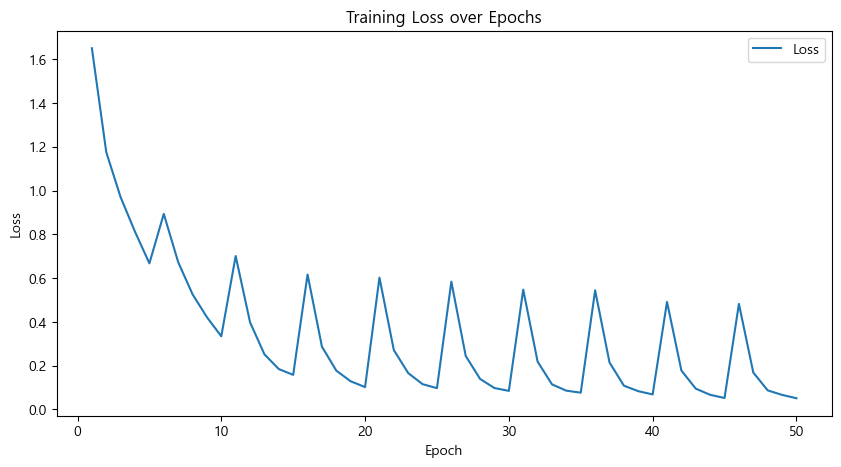

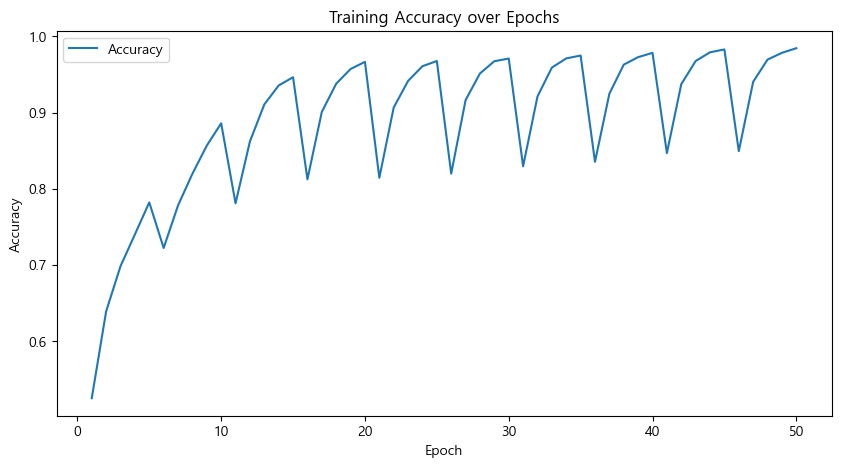

In [8]:
import torch
import os
import matplotlib.pyplot as plt

checkpoint_dir = './final_checkpoint'
num_splits = 10
num_epochs = 5

# Loss와 Accuracy를 저장할 리스트
loss_list = []
accuracy_list = []

# 각 체크포인트에서 데이터 추출
for split_index in range(num_splits):
    for epoch in range(num_epochs):
        checkpoint_path = os.path.join(checkpoint_dir, f'subset_{split_index + 1}_epoch_{epoch + 1}_checkpoint.pth')
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
            loss_list.append(checkpoint['loss'])
            accuracy_list.append(checkpoint['accuracy'])

# 손실(Loss) 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_list) + 1), loss_list, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# 정확도(Accuracy) 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_list) + 1), accuracy_list, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()


NameError: name 'DriverMonitoringDataset' is not defined